<a href="https://colab.research.google.com/github/AndreiAf02/Math509Project_Public/blob/main/509ProjectV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Math 509 - Final Project

##The Influential Predictors of Inflation and Gold Price



## Andrei Afilipoaei, Binbing Wu, Ziqiu Wan

In this project, we wish to analyze the nature and significance of the relationship between inflation in the United States (measured by CPI-U) and a variety of potential influential factors, including prime interest rate, GDP growth, West Texas Intermediate (WTI) Oil price, S&P 500 stock index, and monetary base (money supply). For this purpose, we elected to use the monthly data collected from January 1960 to June 2023.

The CPI-U (Consumer Price Index for all Urban Consumers) was adapted from the data given by the Bureau of Labor Statistics ([CPI](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SA0)), using annual compounding of the monthly change by the equation $((1+\Delta CPI/100)^{12} -1)*100$.

Meanwhile, the Monetary Base, Bank Prime Loan Rate, GDP, and Oil Price were obtained from *Federal Reserve Economic Data* ([monetary base](https://fred.stlouisfed.org/series/BOGMBASE), [prime rate](https://fred.stlouisfed.org/series/DPRIME), [GDP](https://fred.stlouisfed.org/series/GDP), and [WTI Oil](https://fred.stlouisfed.org/series/WTISPLC)). Data for the S&P 500 stock index was obtained from *Official Data* ([S&P500](https://www.officialdata.org/us/stocks/s-p-500/1900)).

Note that the GDP data was recorded only quarterly, so we interpolated the GDP monthly percentage change using the equation $((GDP(Q_{n+1})/GDP(Q_n))^{1/3}-1)*100 $.

The data for gold is obtained in two parts: from January 1971 to December 2000, and from January 2001 to June 2023. The data from 1971-2000 was obtained from [Gold1](https://sdbullion.com/gold-prices-1971), while the data from 2001-2023 was obtained from [Gold2](https://www.indexmundi.com/commodities/?commodity=gold&months=300). The gold data is recorded as the monthly percentage change in the gold price. Prior to 1971, the US dollar was fixed to a gold standard ([Zoeller and Bandelj, 2019](https://doi.org/10.1177/2378023119841812)), making any data prior to that year effectively meaningless; hence, we only recorded gold prices for 1971 on.  

Several datapoints showed extraordinary (outlier) behavior, notably for the months of October, November, and December 2008, January 2009, and March, April and May 2020; since these arose from extraordinary circumstances (the 2008 Great Recession and the 2020 COVID lockdowns), we dropped these datapoints from our dataset.  




In [ ]:
!pip install git+https://github.com/BirkhoffG/causalgraphicalmodels.git

  Cloning https://github.com/BirkhoffG/causalgraphicalmodels.git to /tmp/pip-req-build-_gf_8ccd
  Running command git clone --filter=blob:none --quiet https://github.com/BirkhoffG/causalgraphicalmodels.git /tmp/pip-req-build-_gf_8ccd
  Resolved https://github.com/BirkhoffG/causalgraphicalmodels.git to commit cd178afc246160d1d0ec996a4ec0652cba580205
  Preparing metadata (setup.py) ... done
  Created wheel for causalgraphicalmodels: filename=causalgraphicalmodels-0.0.5-py3-none-any.whl size=10533 sha256=0eae55cd5feea7949453361177c5600158f14e175217aeed3d9321480bc1138a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jp5_5ncz/wheels/20/c2/cd/f747d458f9e2ddebdc0d90760b96441c2676e0b2f4e25cc33a
Successfully built causalgraphicalmodels


In [ ]:
from causalgraphicalmodels import CausalGraphicalModel
import causalgraphicalmodels as cgm

In [73]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm
import seaborn as sns
import arviz as az ## This is new, but it is installed along with PyMC3



import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions
    except for the last index parameters while the last (rightmost)
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    ## quantile(x, [(1 - prob)/2, (1 + prob)/2], axis=-1)
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


In [74]:
path_to_data = 'https://raw.githubusercontent.com/AndreiAf02/Math509Project_Public/main/'
data_all = pd.read_csv(path_to_data + "inflation.csv", sep=",", header=0)
data_all


,Date,BOGMBASE,Money Base Change,DPRIME,GDP,SPIndex,Oil,CPI.U,GoldChange
0,1960-01-01,50700,1.807229,5.00,0.878128,-0.0361,0.000000,-1.193422,NaN
1,1960-02-01,49600,-2.169625,5.00,-0.096411,-0.0108,0.000000,1.206622,NaN
2,1960-03-01,49500,-0.201613,5.00,-0.096411,0.0158,0.000000,0.000000,NaN
3,1960-04-01,49700,0.404040,5.00,-0.096411,-0.0062,0.000000,4.907021,NaN
4,1960-05-01,49700,0.000000,5.00,0.277929,0.0399,0.000000,1.206622,NaN
...,...,...,...,...,...,...,...,...,...
750,2023-02-01,5321600,-0.138863,7.50,0.309099,-0.0259,-1.651306,4.907021,-5.6535
751,2023-03-01,5571500,4.695956,7.75,0.309099,0.0400,-4.620591,1.206622,1.8364
752,2023-04-01,5593100,0.387687,8.00,0.309099,0.0060,8.419760,4.907021,-4.7479
753,2023-05-01,5569600,-0.420161,8.00,0.685690,0.0480,-9.905601,1.206622,-0.9716


In [ ]:
data_all['CPI.U'].mean()

3.90375221533245

## Previous work:

In the previous analysis of this dataset, Andrei performed a frequentist analysis of the multiple linear regression model using R. Ziqiu Wan further developed this analysis by introducing data separation into training and testing sets (which Andrei did not do previously) and observing the correlation matrix and model parameter estimates.



In [ ]:
cleaned_data = data_all.drop(columns=['GoldChange'])
cleaned_data

,Date,BOGMBASE,Money Base Change,DPRIME,GDP,SPIndex,Oil,CPI.U
0,1960-01-01,50700,1.807229,5.00,0.878128,-0.0361,0.000000,-1.193422
1,1960-02-01,49600,-2.169625,5.00,-0.096411,-0.0108,0.000000,1.206622
2,1960-03-01,49500,-0.201613,5.00,-0.096411,0.0158,0.000000,0.000000
3,1960-04-01,49700,0.404040,5.00,-0.096411,-0.0062,0.000000,4.907021
4,1960-05-01,49700,0.000000,5.00,0.277929,0.0399,0.000000,1.206622
...,...,...,...,...,...,...,...,...
750,2023-02-01,5321600,-0.138863,7.50,0.309099,-0.0259,-1.651306,4.907021
751,2023-03-01,5571500,4.695956,7.75,0.309099,0.0400,-4.620591,1.206622
752,2023-04-01,5593100,0.387687,8.00,0.309099,0.0060,8.419760,4.907021
753,2023-05-01,5569600,-0.420161,8.00,0.685690,0.0480,-9.905601,1.206622


In [ ]:
correlation_matrix = cleaned_data.drop(columns=['BOGMBASE', 'Date']).corr()
# print(correlation_matrix[['CPI.U']])
print(correlation_matrix)

                   Money Base Change    DPRIME       GDP   SPIndex       Oil  \
Money Base Change           1.000000 -0.012077 -0.016971  0.050880  0.063058   
DPRIME                     -0.012077  1.000000  0.142556  0.010509  0.021733   
GDP                        -0.016971  0.142556  1.000000  0.179267  0.058932   
SPIndex                     0.050880  0.010509  0.179267  1.000000 -0.011931   
Oil                         0.063058  0.021733  0.058932 -0.011931  1.000000   
CPI.U                      -0.030389  0.445513  0.271077 -0.117700  0.289595   

                      CPI.U  
Money Base Change -0.030389  
DPRIME             0.445513  
GDP                0.271077  
SPIndex           -0.117700  
Oil                0.289595  
CPI.U              1.000000  


In [ ]:
correlation_matrix.style.background_gradient(cmap='coolwarm')

,Money Base Change,DPRIME,GDP,SPIndex,Oil,CPI.U
Money Base Change,1.000000,-0.012077,-0.016971,0.050880,0.063058,-0.030389
DPRIME,-0.012077,1.000000,0.142556,0.010509,0.021733,0.445513
GDP,-0.016971,0.142556,1.000000,0.179267,0.058932,0.271077
SPIndex,0.050880,0.010509,0.179267,1.000000,-0.011931,-0.117700
Oil,0.063058,0.021733,0.058932,-0.011931,1.000000,0.289595
CPI.U,-0.030389,0.445513,0.271077,-0.117700,0.289595,1.000000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
X = cleaned_data.drop(columns=['BOGMBASE', 'Date', 'CPI.U'])
y = cleaned_data['CPI.U']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, RMSE: {rmse}, R^2: {r2}")

coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

MSE: 8.246673139284495, RMSE: 2.8717021327575907, R^2: 0.3029736902844762
                   Coefficient
Money Base Change    -0.085413
DPRIME                0.486460
GDP                   2.388169
SPIndex             -18.791519
Oil                   0.108090


# Part 1:
**Analyzing the important factors of Inflation:**

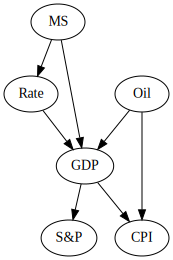

In [ ]:
## DAG plot of the different factors:
CausalGraphicalModel(
    nodes=['CPI', 'Rate', 'GDP', 'S&P', 'Oil', 'MS'], edges=[('GDP', 'CPI'), ('GDP', 'S&P'), ('MS', 'Rate'), ('Rate', 'GDP'), ('Oil', 'CPI'), ('Oil', 'GDP'), ('MS', 'GDP')]
).draw()

The processes of the Directed Acyclic Graph above can be summarized as follows:
* The Money Supply (MS) directly influences the interest rate (Rate) and economic growth (GDP)
* The Rate, in turn, influences the GDP growth.
* Oil price also influences economic well-being, and hence affects GDP growth.
* The GDP growth then influences investor optimism/pessimism and hence influences the stock market (including the S&P 500 stock index).
* GDP growth also provokes price growth in consumer items, leading to CPI growth (inflation).
* Oil price increases further cause the producer cost of consumer items to rise, thereby bringing CPI growth.
* Since stock market does not directly affect inflation, we conclude that any correlation between S&P 500 stock index and CPI inflation is spurious.


We now proceed to analyze the nature and significance of the relationship between CPI and the predictors of Interest Rate, Oil price, GDP growth, and Money Supply change, respectively.

## Inflation, Interest Rate & Oil Price change:

To begin, we observe that secondary (unwanted) paths between interest rate and oil price and CPI inflation can be closed by conditioning on GDP. Therefore, to find the relationship between interest rate and oil price as predictors and inflation as response variable, we construct a prior that conditions on GDP.

For this, we observe that the mean of CPI inflation is approximately 3.90%, so we take the intercept $\alpha$ to have a mean of 4 and standard deviation of 2. Furthermore, we take a slightly wider distribution of $\sigma$. Because we do not know the nature of the relationship between inflation and interest rate and oil price, we take a prior of the $\beta$ estimates to be centered at 0, with standard deviation at 1.

This takes the form:

\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{R}(R_{i}-\bar{R}) + \beta_{W}(W_{i}-\bar{W}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{R} &\sim \text{Normal}(0, 1) \\
    \beta_{W} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $W_i$ denotes the West Texas Intermediate oil price change.


In [ ]:
with pm.Model() as model_project1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_R = pm.Normal('beta_R', mu=0, sigma=1)
    beta_W = pm.Normal('beta_W', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = alpha + beta_R*(data_all['DPRIME']-data_all['DPRIME'].mean()) + beta_W*(data_all['Oil']-data_all['Oil'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_all['CPI.U'])
    _model_project1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project1_mcmc_samples = _model_project1_mcmc_samples.posterior.to_dataframe()
model_project1_mcmc_samples

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


beta_R    beta_W     alpha     sigma        mu
chain draw mu_dim_0                                                  
0     0    0         0.503300  0.115254  3.906762  3.259269  2.798566
           1         0.503300  0.115254  3.906762  3.259269  2.798566
           2         0.503300  0.115254  3.906762  3.259269  2.798566
           3         0.503300  0.115254  3.906762  3.259269  2.798566
           4         0.503300  0.115254  3.906762  3.259269  2.798566
...                       ...       ...       ...       ...       ...
3     999  750       0.496658  0.120890  3.866811  3.269287  3.809825
           751       0.496658  0.120890  3.866811  3.269287  3.575032
           752       0.496658  0.120890  3.866811  3.269287  5.275646
           753       0.496658  0.120890  3.866811  3.269287  3.060291
           754       0.496658  0.120890  3.866811  3.269287  4.157323

[3020000 rows x 5 columns]

<Axes: >

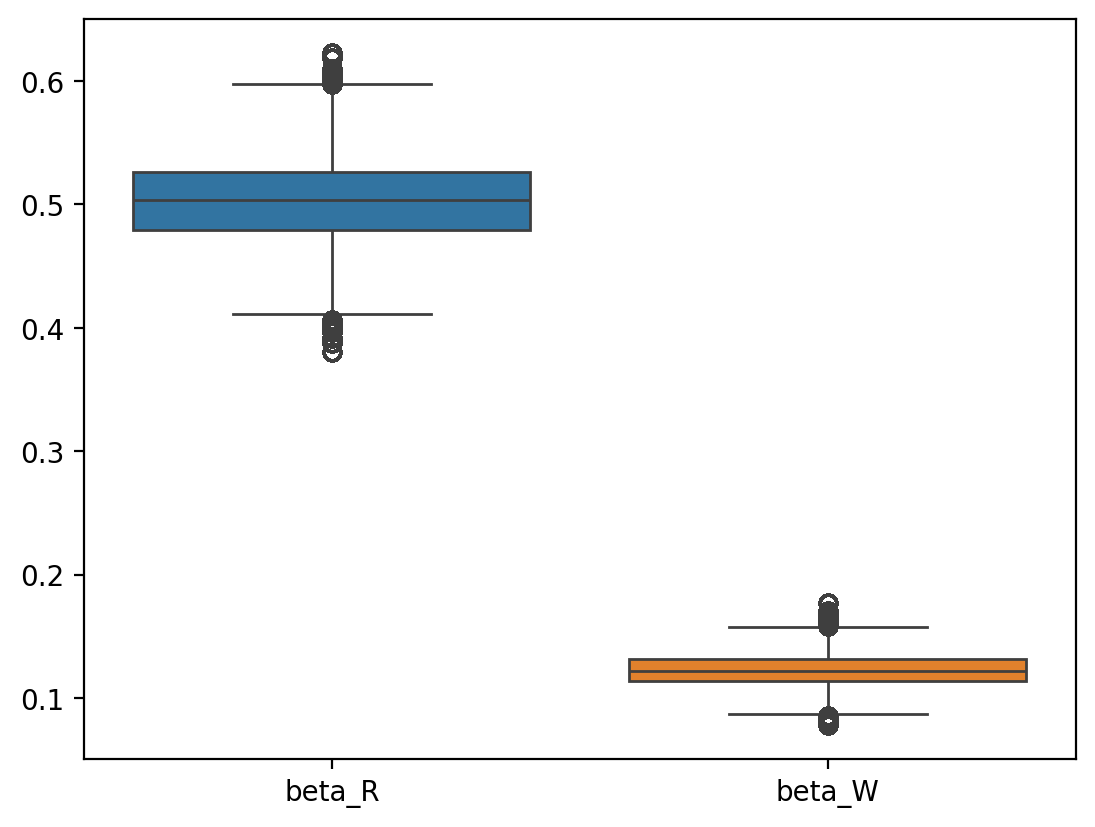

In [ ]:
sns.boxplot(data=model_project1_mcmc_samples[['beta_R', 'beta_W']])

<Axes: >

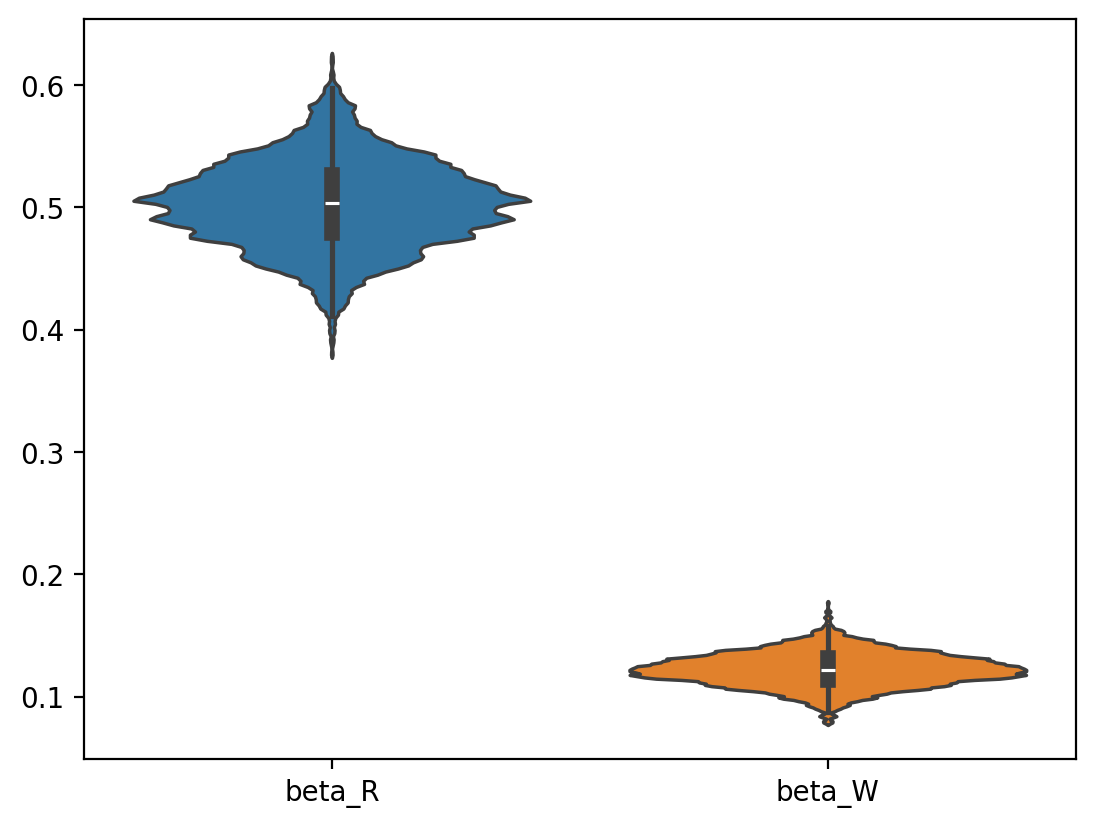

In [ ]:
sns.violinplot(data=model_project1_mcmc_samples[['beta_R', 'beta_W']])

As can be seen, the boxplots for both $\beta_R$ and $\beta_W$ are significantly above 0. Nevertheless, the median value for $\beta_R$ is considerably larger than for $\beta_W$, indicating that interest rate has a larger overall effect on inflation than does the oil price.

Overall, we conclude that **there is a strong positive correlation between inflation as the response variable and interest rate and oil price change as predictors**.

## Inflation & GDP growth:

Now, we turn our attention to analyzing the significance of the relationship between GDP growth and inflation. For this, we take the following prior:

\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{G}(G_{i}-\bar{G}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{G} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $G_i$ denotes the GDP growth rate.

In [ ]:
with pm.Model() as model_gdp1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = alpha + beta_G*(data_all['GDP']-data_all['GDP'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_all['CPI.U'])
    _model_gdp1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gdp1_mcmc_samples = _model_gdp1_mcmc_samples.posterior.to_dataframe()
model_gdp1_mcmc_samples

beta_G     alpha     sigma        mu
chain draw mu_dim_0                                        
0     0    0         2.323903  3.809196  3.673070  4.624983
           1         2.323903  3.809196  3.673070  2.360248
           2         2.323903  3.809196  3.673070  2.360248
           3         2.323903  3.809196  3.673070  2.360248
           4         2.323903  3.809196  3.673070  3.230177
...                       ...       ...       ...       ...
3     999  750       2.422907  4.018532  3.585758  3.490368
           751       2.422907  4.018532  3.585758  3.490368
           752       2.422907  4.018532  3.585758  3.490368
           753       2.422907  4.018532  3.585758  4.402813
           754       2.422907  4.018532  3.585758  4.402813

[3020000 rows x 4 columns]

<Axes: >

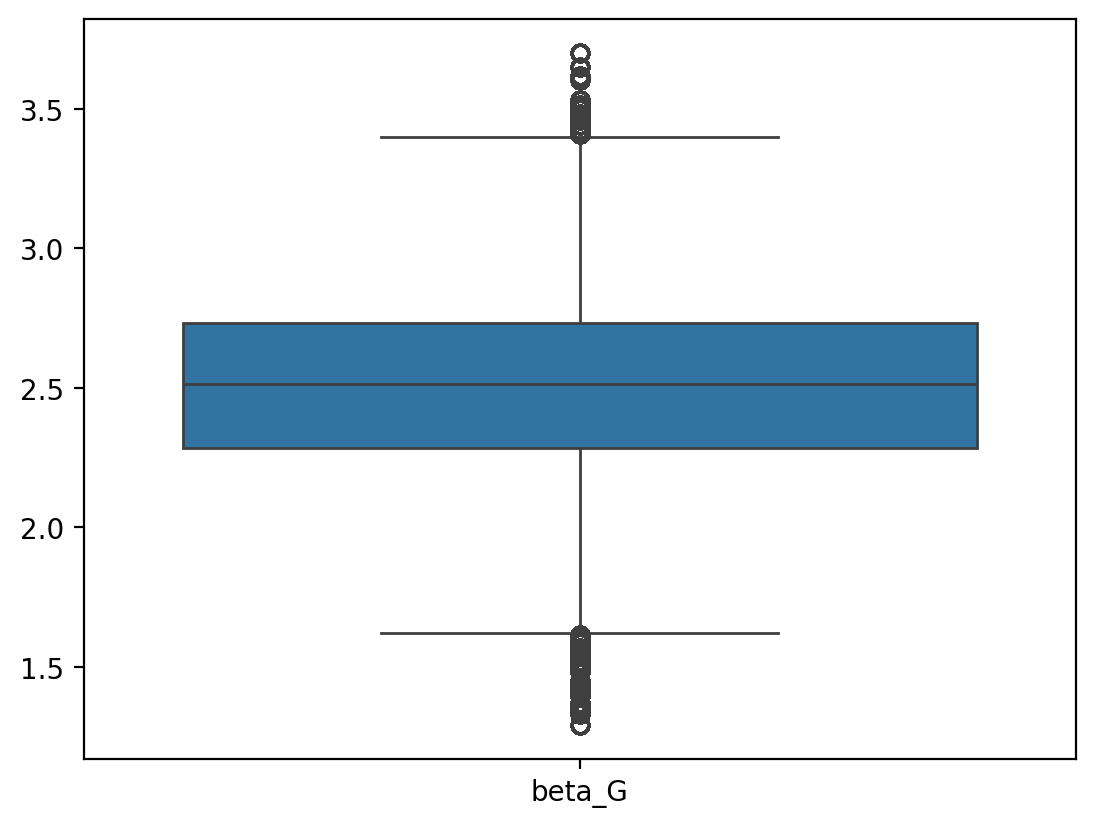

In [ ]:
sns.boxplot(data=model_gdp1_mcmc_samples[['beta_G']])

As can be seen, the MCMC estimate of $\beta_G$ is significantly above 0. This indicates that there is actually a strong positive relationship between GDP and inflation.

**Credibility interval plot for CPI versus Interest rate (holding Oil price change at mean)**:

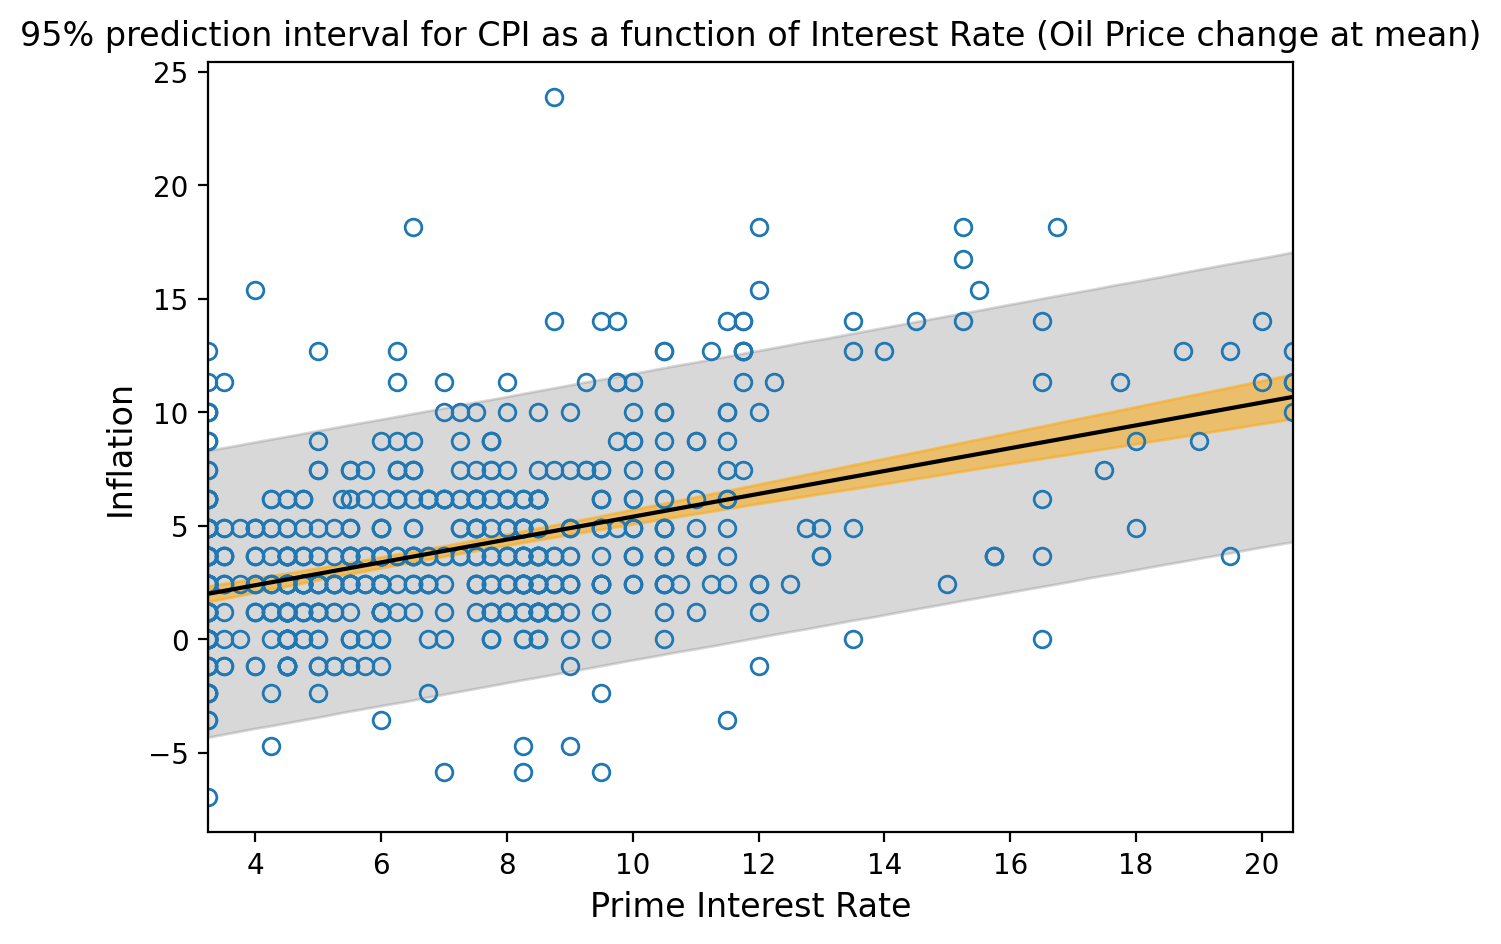

In [ ]:
## Prediction plot for CPI from Interest Rate and Oil MCMC, holding Oil price at its mean:

prob = 0.95 ## for credible intervals

xmin = data_all['DPRIME'].min()
xmax = data_all['DPRIME'].max()
xmean = data_all['DPRIME'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project1_mcmc_samples['beta_R'])[None, :]
sigma_samples = array(model_project1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_all['DPRIME'], data_all['CPI.U'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for CPI as a function of Interest Rate (Oil Price change at mean)')
xlabel('Prime Interest Rate', fontsize=12)
ylabel('Inflation', fontsize=12);

**Credibility Interval plots for Oil and GDP vs. CPI** (Binbing Wu):

## To put! Binbing's Code!

This takes the form:

\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{G}(G_{i}-\bar{G}) + \beta_{O}(O_{i}-\bar{O}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{G} &\sim \text{Normal}(0, 1) \\
    \beta_{O} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $W_i$ denotes the West Texas Intermediate oil price change.

In [ ]:
with pm.Model() as model_cpi_o_g:
    sigma = pm.Exponential('sigma', 1)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    beta_O = pm.Normal('beta_O', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    _mu = alpha + beta_G * (data_all['GDP']-data_all['GDP'].mean()) + beta_O * (data_all['Oil']-data_all['Oil'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_all['CPI.U'])
    _model_cpi_o_g_samples = pm.sample(1000, tune=1000, chains=4)
model_cpi_o_g_samples = _model_cpi_o_g_samples.posterior.to_dataframe()
model_cpi_o_g_samples

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


beta_G    beta_O     alpha     sigma        mu
chain draw mu_dim_0                                                  
0     0    0         2.444705  0.095668  3.910827  3.475626  4.696382
           1         2.444705  0.095668  3.910827  3.475626  2.313922
           2         2.444705  0.095668  3.910827  3.475626  2.313922
           3         2.444705  0.095668  3.910827  3.475626  2.313922
           4         2.444705  0.095668  3.910827  3.475626  3.229071
...                       ...       ...       ...       ...       ...
3     999  750       2.312084  0.117193  3.977075  3.521040  3.190567
           751       2.312084  0.117193  3.977075  3.521040  2.842589
           752       2.312084  0.117193  3.977075  3.521040  4.370821
           753       2.312084  0.117193  3.977075  3.521040  3.093935
           754       2.312084  0.117193  3.977075  3.521040  4.037047

[3020000 rows x 5 columns]

<Axes: >

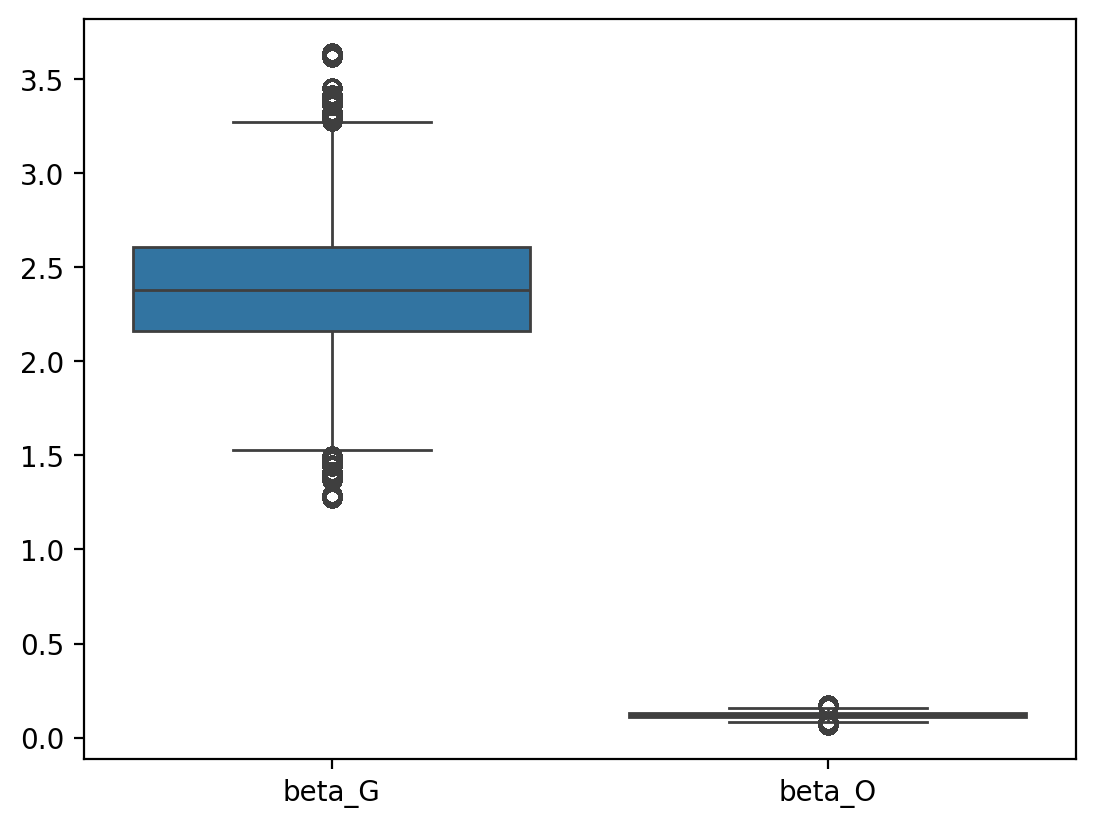

In [ ]:
sns.boxplot(data=model_cpi_o_g_samples[['beta_G', 'beta_O']])

<Axes: >

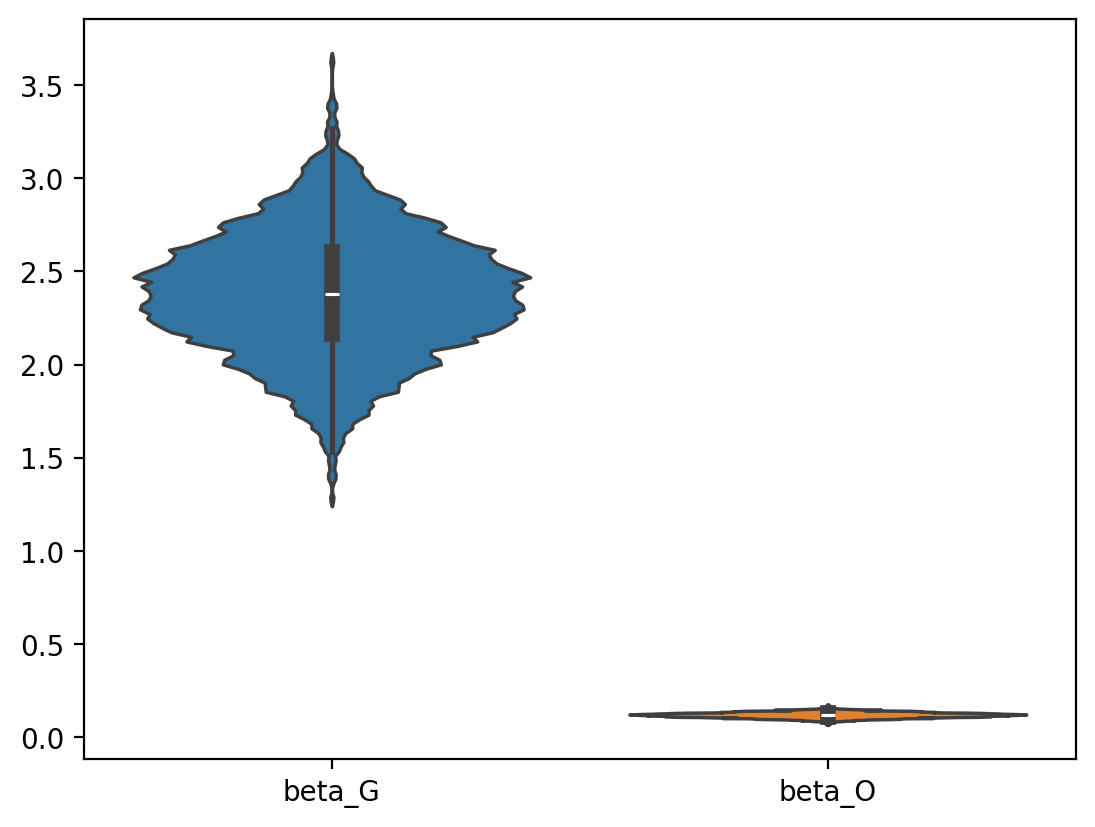

In [ ]:
sns.violinplot(data=model_cpi_o_g_samples[['beta_G', 'beta_O']])

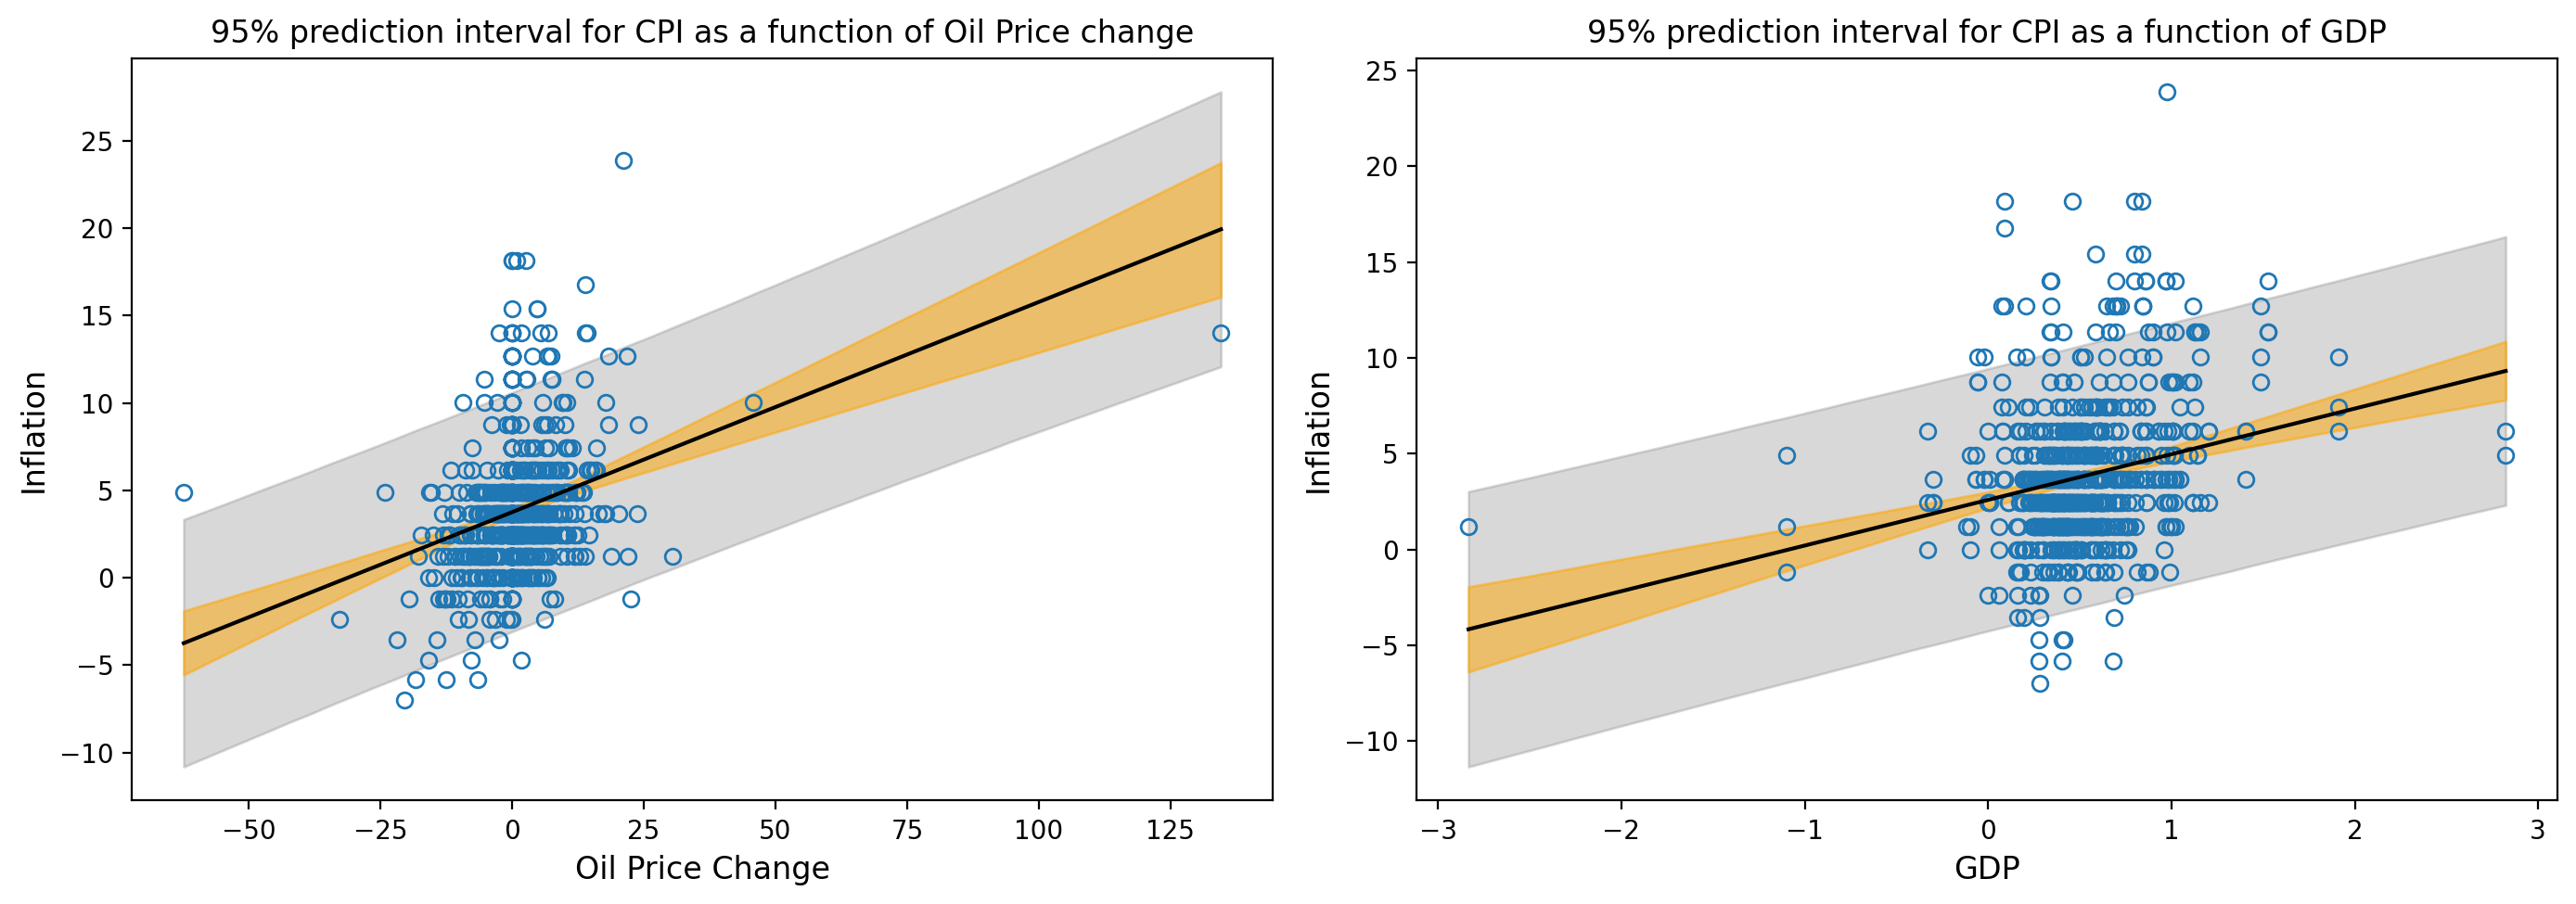

In [ ]:
def plot_prediction_intervals_corrected(x, xmean, beta_samples, data_x, data_y, title_text, xlabel_text):
    N_weight = len(x)
    alpha_samples = array(model_cpi_o_g_samples['alpha'])
    sigma_samples = array(model_cpi_o_g_samples['sigma'])

    # Compute mean values
    mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)
    mu_samples = alpha_samples[:, None] + beta_samples[:, None]*(x - xmean)

    N_posterior_samples = alpha_samples.size
    prob = 0.95

    #### the mean posterior average height
    mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

    #### collect samples of the average height
    mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
    ## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
    mu_samples_sorted = sort(mu_samples, axis=1)
    index = int(N_posterior_samples*(1 - prob)/2)
    mu_lower = mu_samples_sorted[:, index]
    mu_upper = mu_samples_sorted[:, -index]

    #### Sample the posterior prediction height
    h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
    ## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
    h_samples_sorted = sort(h_samples, axis=1)
    index = int(N_posterior_samples*(1 - prob)/2)
    h_lower = h_samples_sorted[:, index]
    h_upper = h_samples_sorted[:, -index]
    plt.fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
    plt.fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
    plt.plot(data_x, data_y, 'o', mfc='none')
    plt.plot(x, mu_avg, 'k')
    plt.title(title_text)
    plt.xlabel(xlabel_text, fontsize=12)
    plt.ylabel('Inflation', fontsize=12)

# Create subplots with corrected function
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Oil
plt.subplot(1, 2, 1)
xmin, xmax, xmean = data_all['Oil'].min(), data_all['Oil'].max(), data_all['Oil'].mean()
x = linspace(xmin, xmax, 50)
plot_prediction_intervals_corrected(x, xmean, array(model_cpi_o_g_samples['beta_O']), data_all['Oil'], data_all['CPI.U'], '95% prediction interval for CPI as a function of Oil Price change', 'Oil Price Change')

# Plot for GDP
plt.subplot(1, 2, 2)
xmin, xmax, xmean = data_all['GDP'].min(), data_all['GDP'].max(), data_all['GDP'].mean()
x = linspace(xmin, xmax, 50)
plot_prediction_intervals_corrected(x, xmean, array(model_cpi_o_g_samples['beta_G']), data_all['GDP'], data_all['CPI.U'], '95% prediction interval for CPI as a function of GDP', 'GDP')

plt.tight_layout()
plt.show()

## Inflation & Money Supply

Now, we turn our attention to analyzing the effect that changes in money supply have on CPI inflation. Examining the DAG above, we therefore determine that, to do so, we condition on the interest rate, GDP, and oil price. As such, our prior takes the form
\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{M}(M_{i}-\bar{M}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{M} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $M_i$ denotes the change in the money supply.

In [ ]:
with pm.Model() as model_ms1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = alpha + beta_M*(data_all['Money Base Change']-data_all['Money Base Change'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_all['CPI.U'])
    _model_ms1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_ms1_mcmc_samples = _model_ms1_mcmc_samples.posterior.to_dataframe()
model_ms1_mcmc_samples

beta_M     alpha     sigma        mu
chain draw mu_dim_0                                        
0     0    0        -0.059505  3.932380  3.597772  3.854679
           1        -0.059505  3.932380  3.597772  4.091323
           2        -0.059505  3.932380  3.597772  3.974216
           3        -0.059505  3.932380  3.597772  3.938176
           4        -0.059505  3.932380  3.597772  3.962219
...                       ...       ...       ...       ...
3     999  750      -0.025995  3.991086  3.679932  4.007731
           751      -0.025995  3.991086  3.679932  3.882049
           752      -0.025995  3.991086  3.679932  3.994043
           753      -0.025995  3.991086  3.679932  4.015044
           754      -0.025995  3.991086  3.679932  3.985966

[3020000 rows x 4 columns]

<Axes: >

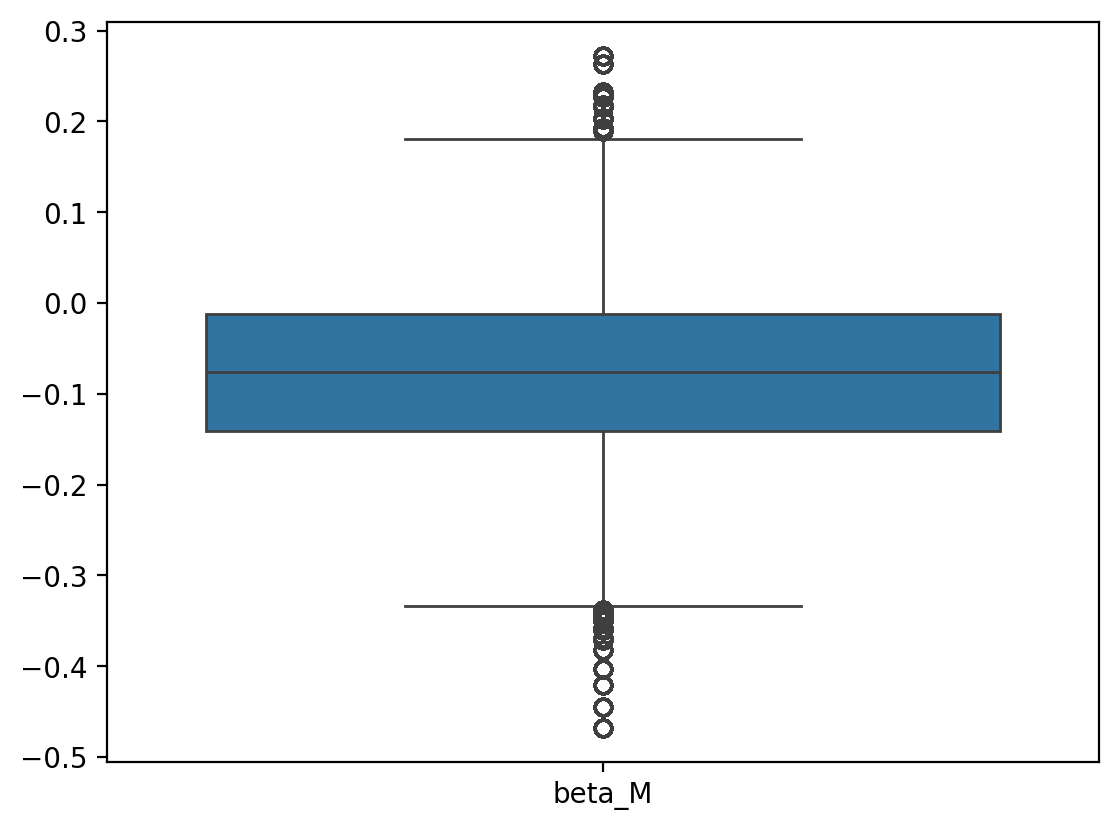

In [ ]:
sns.boxplot(data=model_ms1_mcmc_samples[['beta_M']])

As can be seen, the boxplot median for $\beta_M$ is relatively close to 0, indicating that **there is no significant relationship between money supply change and inflation**.

Note that this only indicates that the effects of an increase in money supply do not translate to an immediate increase in CPI, although the cumulative effect of money supply changes will impact inflation in the long-run.

The 95% credbility interval plot for the CPI inflation versus money supply takes the form:

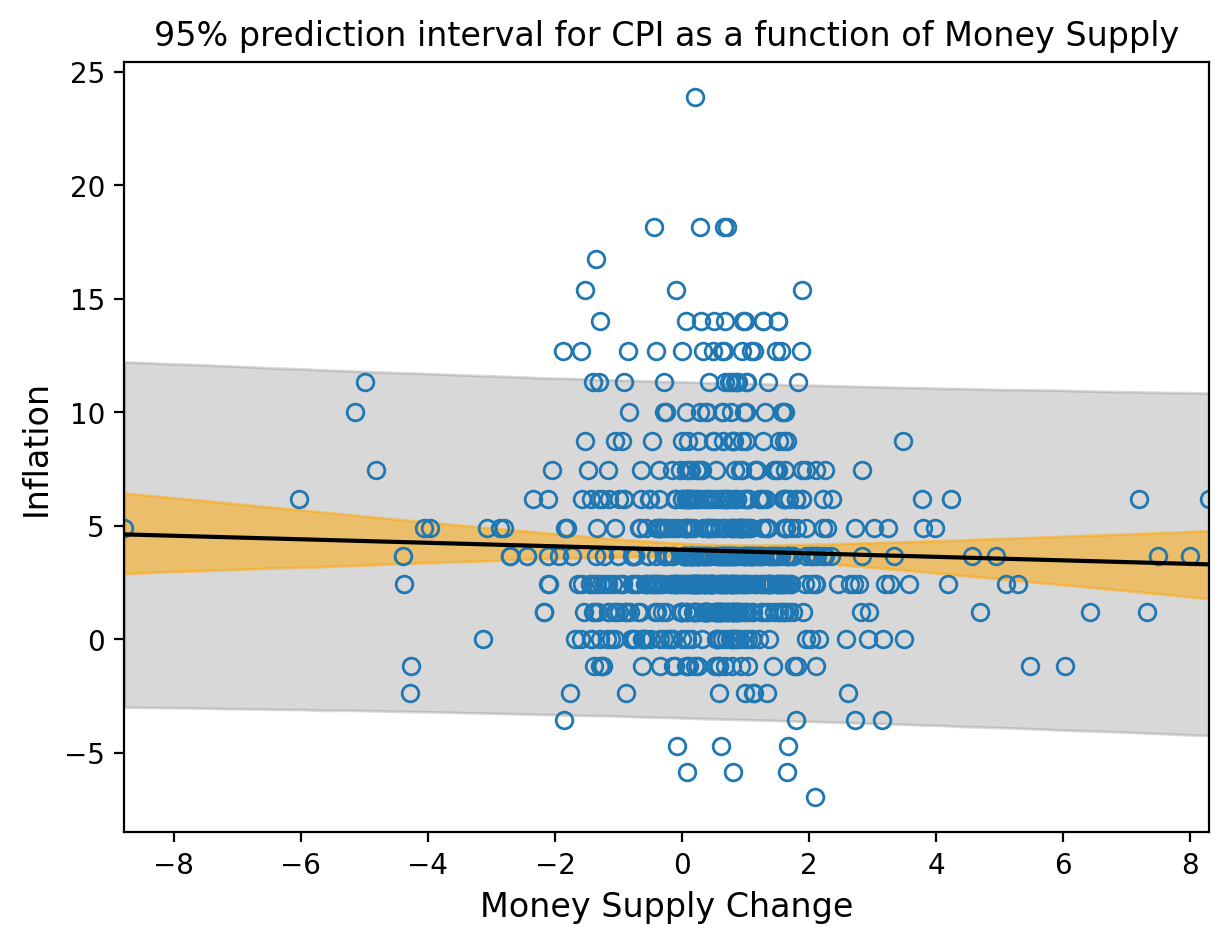

In [ ]:
## Prediction plot for CPI from Interest Rate and Oil MCMC, holding Oil price at its mean:

prob = 0.95 ## for credible intervals

xmin = data_all['Money Base Change'].min()
xmax = data_all['Money Base Change'].max()
xmean = data_all['Money Base Change'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_ms1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_ms1_mcmc_samples['beta_M'])[None, :]
sigma_samples = array(model_ms1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_all['Money Base Change'], data_all['CPI.U'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for CPI as a function of Money Supply')
xlabel('Money Supply Change', fontsize=12)
ylabel('Inflation', fontsize=12);

##1.1 Adding Time component

Based on our observations above, we see that the predicted conditional independence of interest rate given GDP growth does not arise. As such, we add another component (that of time) to (hopefully) close this unconsidered open path. For this purpose, our Directed Acyclic Graph takes the form:

TO PUT WHEN IT WORKS AGAIN!

Our Prior takes the form:

\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{R}(R_{i}-\bar{R}) + \beta_{W}(W_{i}-\bar{W}) + \beta_{IP}(IP_{i}-\bar{IP}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{R} &\sim \text{Normal}(0, 1) \\
    \beta_{W} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $IP_i$ denotes the previous month's inflation rate.

In [100]:
data_all['Inf_Prev']=zeros(755)

n=12

for i in range(n,756):
  data_all['Inf_Prev'][i]=data_all['CPI.U'][i-n]
data_all

<ipython-input-100-629177308a2a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['Inf_Prev'][i]=data_all['CPI.U'][i-n]


,Date,BOGMBASE,Money Base Change,DPRIME,GDP,SPIndex,Oil,CPI.U,GoldChange,Inf_Prev
0,1960-01-01,50700,1.807229,5.00,0.878128,-0.0361,0.000000,-1.193422,NaN,0.000000
1,1960-02-01,49600,-2.169625,5.00,-0.096411,-0.0108,0.000000,1.206622,NaN,0.000000
2,1960-03-01,49500,-0.201613,5.00,-0.096411,0.0158,0.000000,0.000000,NaN,0.000000
3,1960-04-01,49700,0.404040,5.00,-0.096411,-0.0062,0.000000,4.907021,NaN,0.000000
4,1960-05-01,49700,0.000000,5.00,0.277929,0.0399,0.000000,1.206622,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...
750,2023-02-01,5321600,-0.138863,7.50,0.309099,-0.0259,-1.651306,4.907021,-5.6535,8.731066
751,2023-03-01,5571500,4.695956,7.75,0.309099,0.0400,-4.620591,1.206622,1.8364,12.682503
752,2023-04-01,5593100,0.387687,8.00,0.309099,0.0060,8.419760,4.907021,-4.7479,4.907021
753,2023-05-01,5569600,-0.420161,8.00,0.685690,0.0480,-9.905601,1.206622,-0.9716,11.350967


In [ ]:
with pm.Model() as model_project_time1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_R = pm.Normal('beta_R', mu=0, sigma=1)
    beta_W = pm.Normal('beta_W', mu=0, sigma=1)
    beta_T = pm.Normal('beta_T', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = (alpha + beta_R*(data_all['DPRIME']-data_all['DPRIME'].mean())
        + beta_W*(data_all['Oil']-data_all['Oil'].mean()) + beta_T*(data_all['Inf_Prev']-data_all['Inf_Prev'].mean()))
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_all['CPI.U'])
    _model_project_time1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project_time1_mcmc_samples = _model_project_time1_mcmc_samples.posterior.to_dataframe()
model_project_time1_mcmc_samples

beta_R    beta_W    beta_T     alpha     sigma  \
chain draw mu_dim_0                                                     
0     0    0         0.408823  0.120842  0.243176  3.846360  3.154479   
           1         0.408823  0.120842  0.243176  3.846360  3.154479   
           2         0.408823  0.120842  0.243176  3.846360  3.154479   
           3         0.408823  0.120842  0.243176  3.846360  3.154479   
           4         0.408823  0.120842  0.243176  3.846360  3.154479   
...                       ...       ...       ...       ...       ...   
3     999  750       0.276868  0.111565  0.286744  4.015558  3.132594   
           751       0.276868  0.111565  0.286744  4.015558  3.132594   
           752       0.276868  0.111565  0.286744  4.015558  3.132594   
           753       0.276868  0.111565  0.286744  4.015558  3.132594   
           754       0.276868  0.111565  0.286744  4.015558  3.132594   

                           mu  
chain draw mu_dim_0            
0     0    0         1.988444  
           1         1.988444  
           2         1.988444  
           3         1.988444  
           4         1.988444  
...                       ...  
3     999  750       5.275927  
           751       6.146926  
           752       5.441417  
           753       5.244711  
           754       7.369767  

[3020000 rows x 6 columns]

<Axes: >

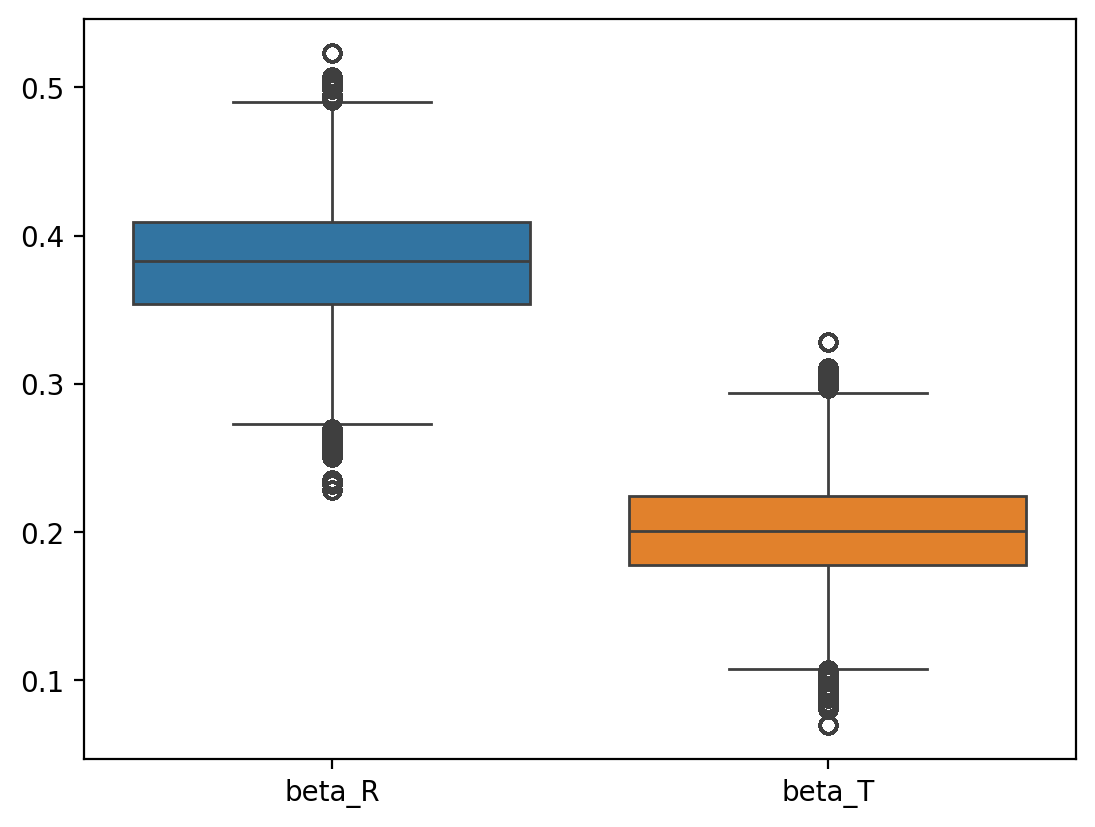

In [ ]:
sns.boxplot(data=model_project_time1_mcmc_samples[['beta_R', 'beta_T']])

In [101]:
correlation_matrix = data_all.drop(columns=['BOGMBASE', 'Date', 'GoldChange']).corr()
# print(correlation_matrix[['CPI.U']])
print(correlation_matrix)

                   Money Base Change    DPRIME       GDP   SPIndex       Oil  \
Money Base Change           1.000000 -0.012077 -0.016971  0.050880  0.063058   
DPRIME                     -0.012077  1.000000  0.142556  0.010509  0.021733   
GDP                        -0.016971  0.142556  1.000000  0.179267  0.058932   
SPIndex                     0.050880  0.010509  0.179267  1.000000 -0.011931   
Oil                         0.063058  0.021733  0.058932 -0.011931  1.000000   
CPI.U                      -0.030389  0.445513  0.271077 -0.117700  0.289595   
Inf_Prev                    0.001889  0.526239  0.213064  0.048177 -0.012527   

                      CPI.U  Inf_Prev  
Money Base Change -0.030389  0.001889  
DPRIME             0.445513  0.526239  
GDP                0.271077  0.213064  
SPIndex           -0.117700  0.048177  
Oil                0.289595 -0.012527  
CPI.U              1.000000  0.373788  
Inf_Prev           0.373788  1.000000  


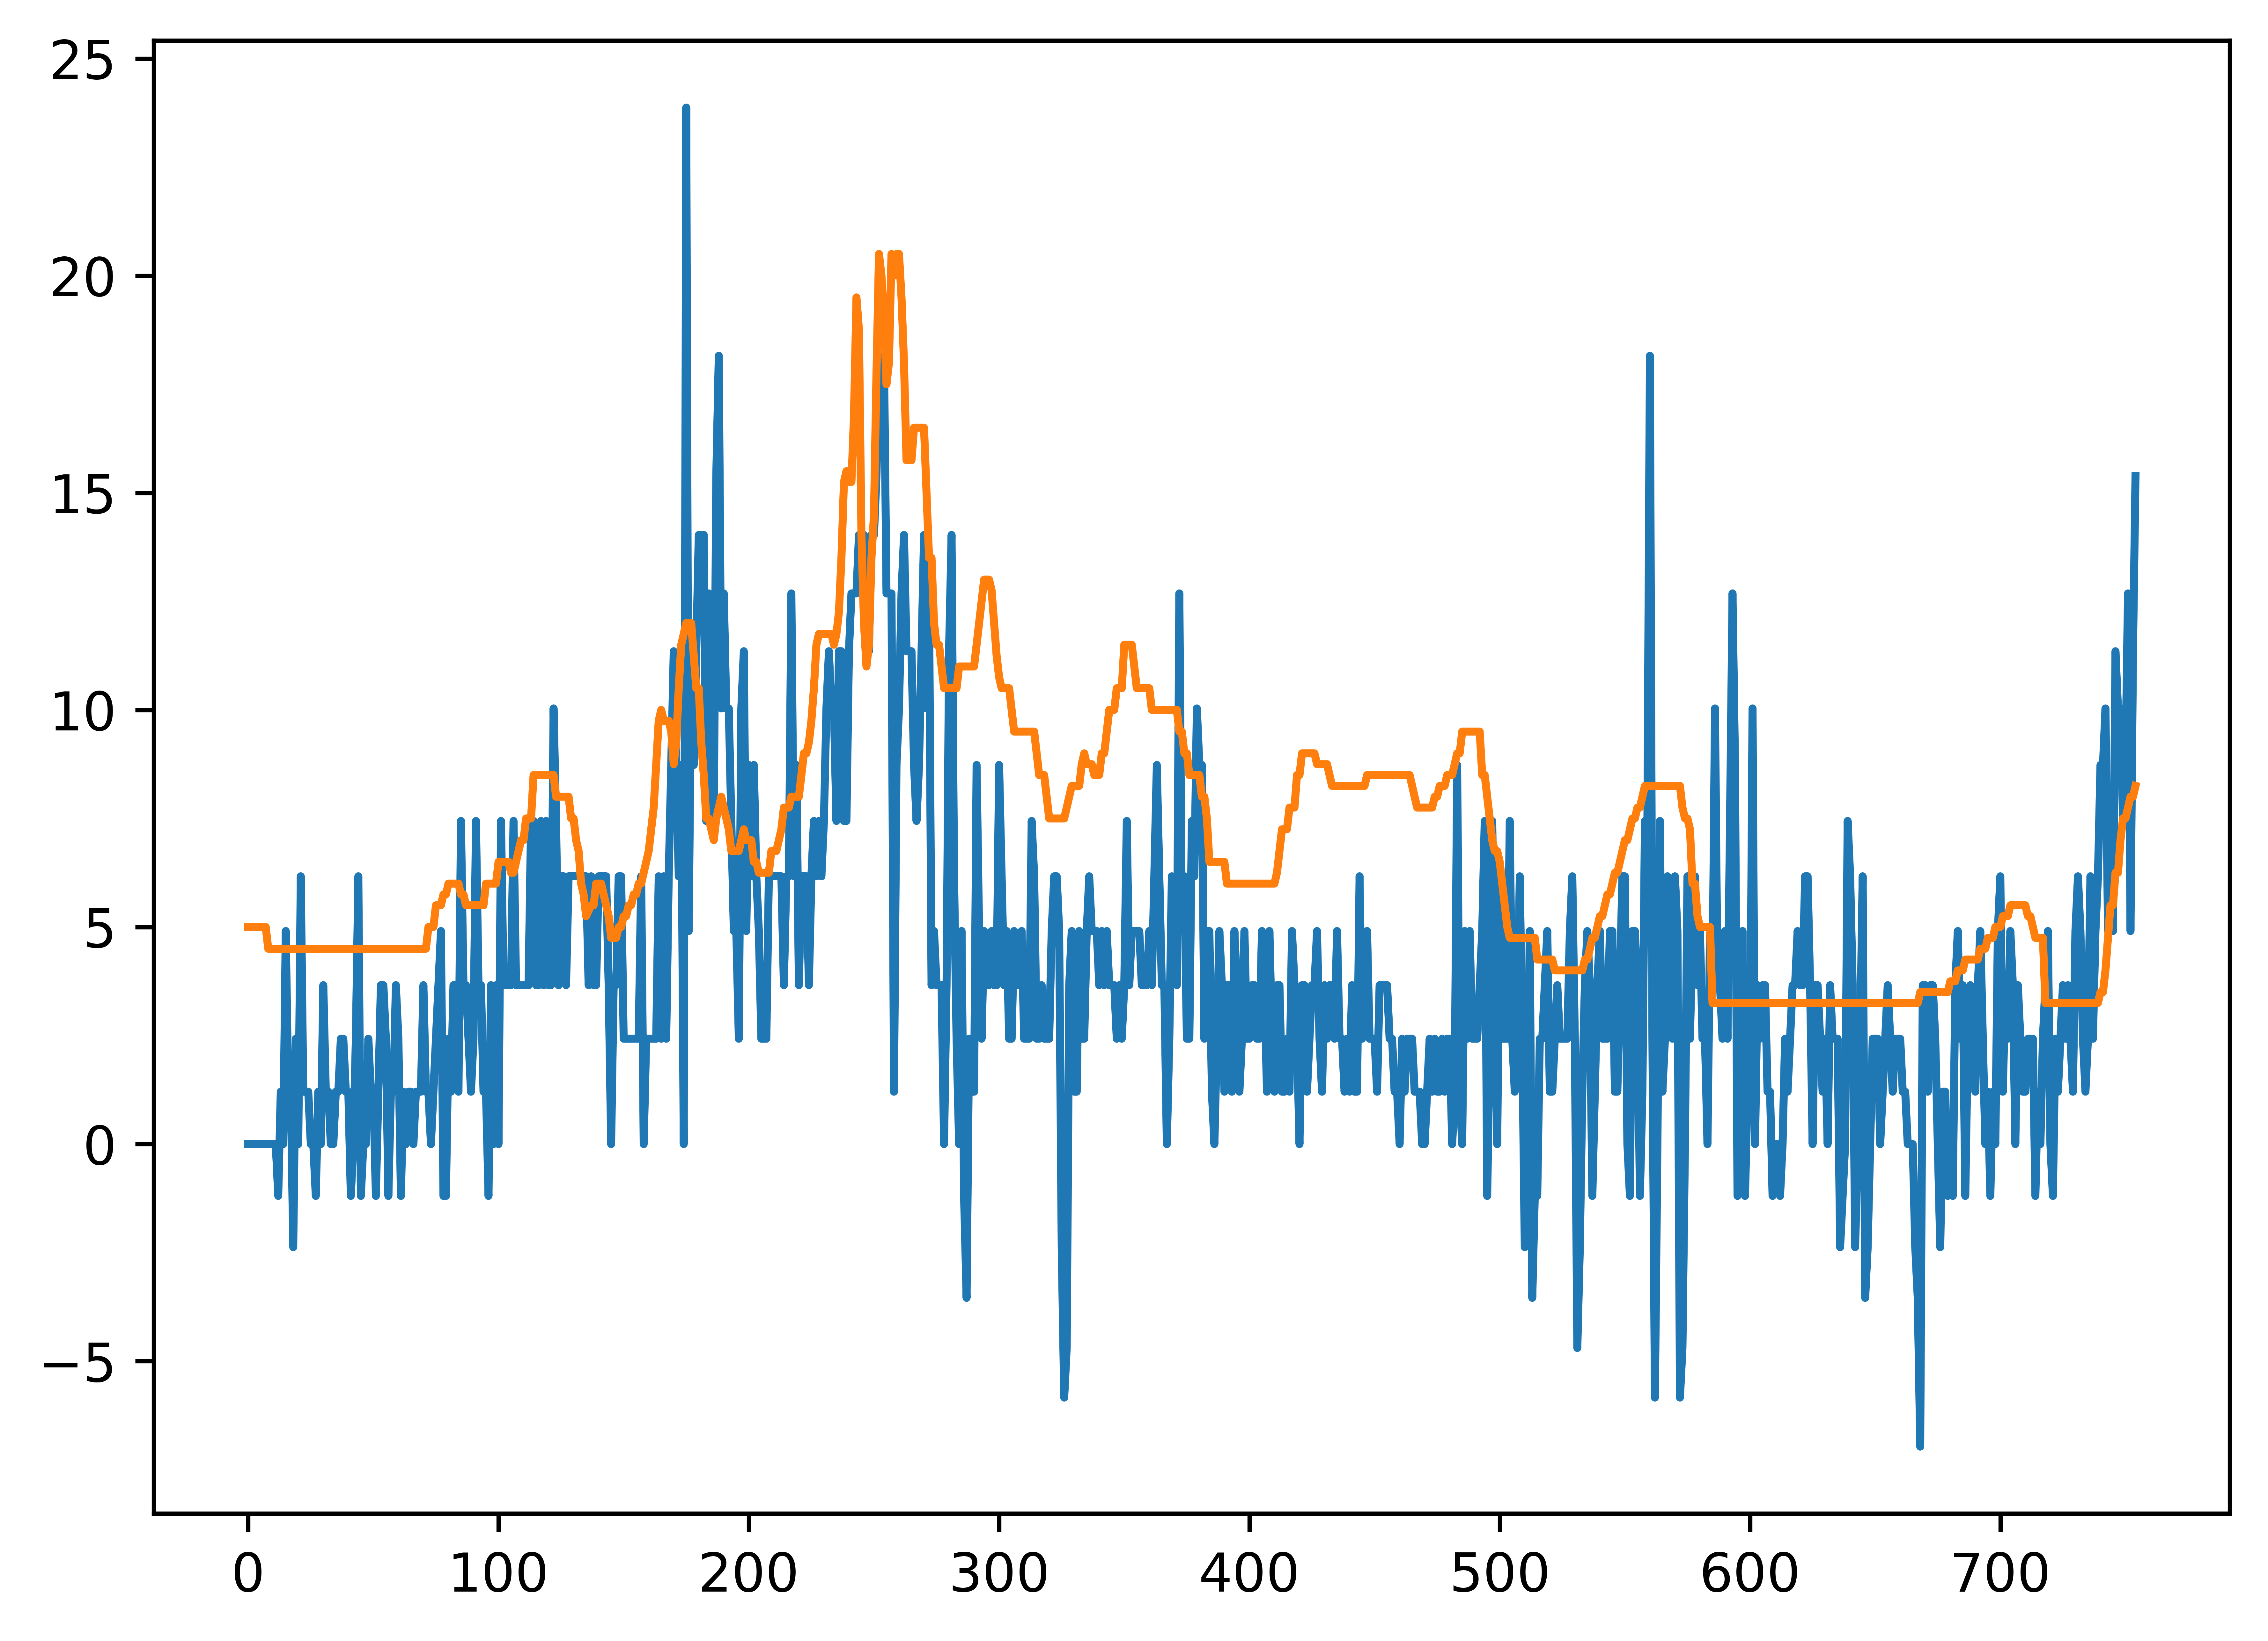

In [105]:
figure(1, [7, 5], dpi=600)
plt.plot(data_all['Inf_Prev'])
plt.plot(data_all['DPRIME'])


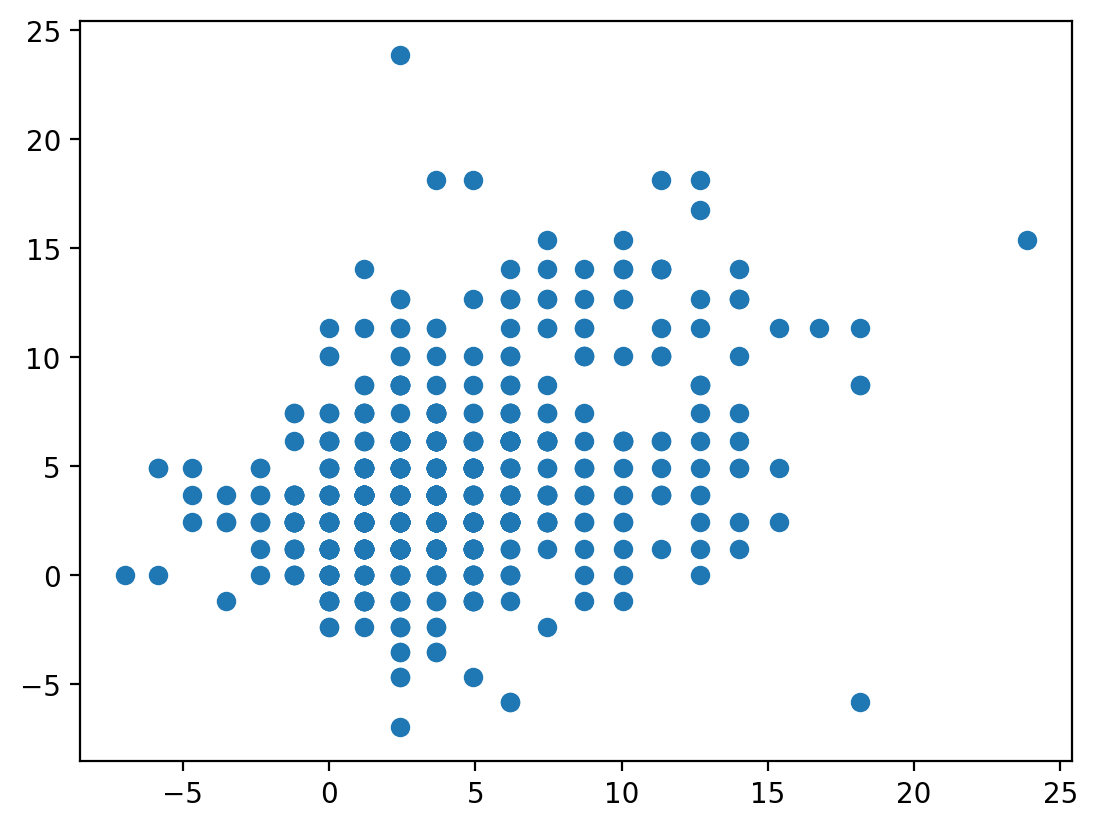

In [ ]:
plt.plot(data_all['Inf_Prev'], data_all['CPI.U'],'o')

## Part 1.2: Checking linearity Assumptions

## (Dropping influential datapoints)

**Oil price analysis without influential datapoints**:

Returning to our MCMC analysis of CPI versus interest rate and oil price, we can clearly see that the credibility interval plot for CPI versus Oil price
change is heavily skewed by several extreme datapoints; these points correspond to extraordinary economic shocks that brought extreme overnight fluctuations in the price of oil. As such, we investigate how our MCMC model behaves if we drop these extreme influential data points, to verify whether our linearity assumption is acceptable.  

In [ ]:
data_new = data_all[(data_all['Oil']<130) & (data_all['Oil']> -60)]
data_new

,Date,BOGMBASE,Money Base Change,DPRIME,GDP,SPIndex,Oil,CPI.U,GoldChange
0,1960-01-01,50700,1.807229,5.00,0.878128,-0.0361,0.000000,-1.193422,NaN
1,1960-02-01,49600,-2.169625,5.00,-0.096411,-0.0108,0.000000,1.206622,NaN
2,1960-03-01,49500,-0.201613,5.00,-0.096411,0.0158,0.000000,0.000000,NaN
3,1960-04-01,49700,0.404040,5.00,-0.096411,-0.0062,0.000000,4.907021,NaN
4,1960-05-01,49700,0.000000,5.00,0.277929,0.0399,0.000000,1.206622,NaN
...,...,...,...,...,...,...,...,...,...
750,2023-02-01,5321600,-0.138863,7.50,0.309099,-0.0259,-1.651306,4.907021,-5.6535
751,2023-03-01,5571500,4.695956,7.75,0.309099,0.0400,-4.620591,1.206622,1.8364
752,2023-04-01,5593100,0.387687,8.00,0.309099,0.0060,8.419760,4.907021,-4.7479
753,2023-05-01,5569600,-0.420161,8.00,0.685690,0.0480,-9.905601,1.206622,-0.9716


Our prior still takes the form:
\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{R}(R_{i}-\bar{R}) + \beta_{W}(W_{i}-\bar{W}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{R} &\sim \text{Normal}(0, 1) \\
    \beta_{W} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}

In [ ]:
with pm.Model() as model_project2:
    sigma = pm.Exponential('sigma', 0.5)
    beta_R = pm.Normal('beta_R', mu=0, sigma=1)
    beta_W = pm.Normal('beta_W', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = alpha + beta_R*(data_new['DPRIME']-data_new['DPRIME'].mean()) + beta_W*(data_new['Oil']-data_new['Oil'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_new['CPI.U'])
    _model_project2_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_project2_mcmc_samples = _model_project2_mcmc_samples.posterior.to_dataframe()
model_project2_mcmc_samples

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


beta_R    beta_W     alpha     sigma        mu
chain draw mu_dim_0                                                  
0     0    0         0.468761  0.167675  3.913019  3.176945  2.850161
           1         0.468761  0.167675  3.913019  3.176945  2.850161
           2         0.468761  0.167675  3.913019  3.176945  2.850161
           3         0.468761  0.167675  3.913019  3.176945  2.850161
           4         0.468761  0.167675  3.913019  3.176945  2.850161
...                       ...       ...       ...       ...       ...
3     999  748       0.511191  0.176906  3.803985  3.244909  3.634730
           749       0.511191  0.176906  3.803985  3.244909  3.237242
           750       0.511191  0.176906  3.803985  3.244909  5.671961
           751       0.511191  0.176906  3.803985  3.244909  2.430088
           752       0.511191  0.176906  3.803985  3.244909  3.981547

[3012000 rows x 5 columns]

<Axes: >

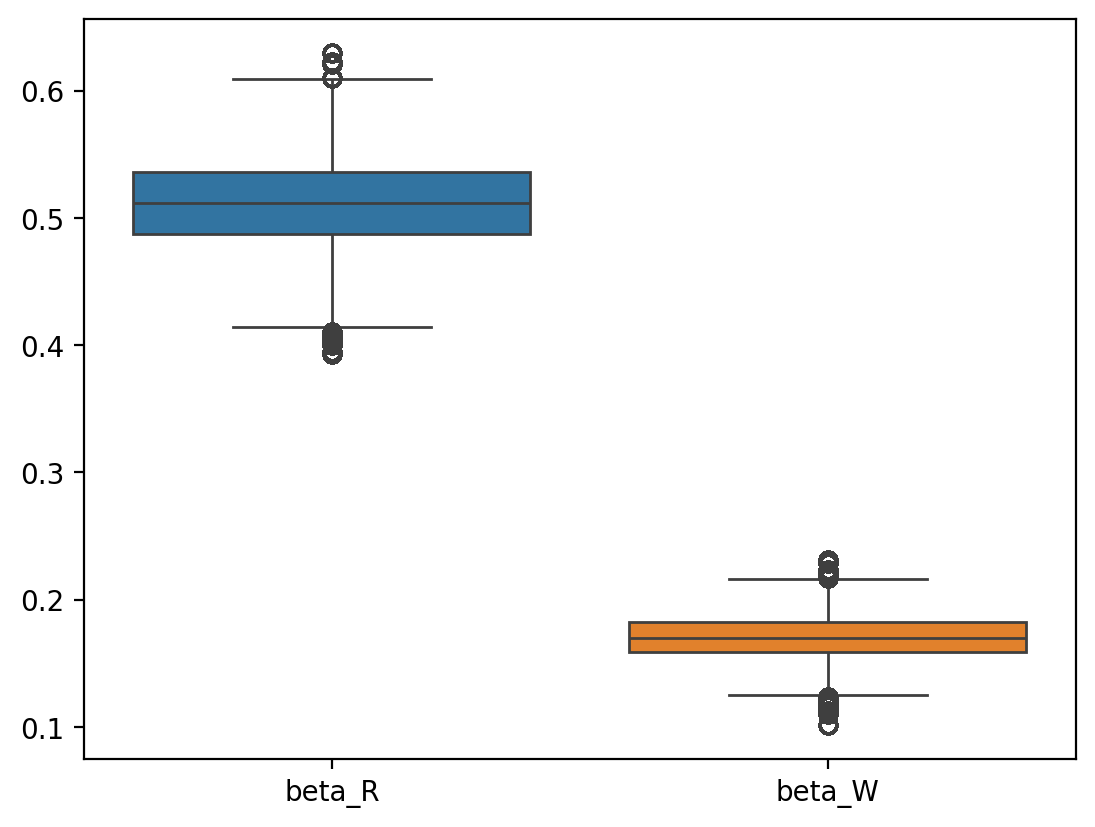

In [ ]:
sns.boxplot(data=model_project2_mcmc_samples[['beta_R', 'beta_W']])

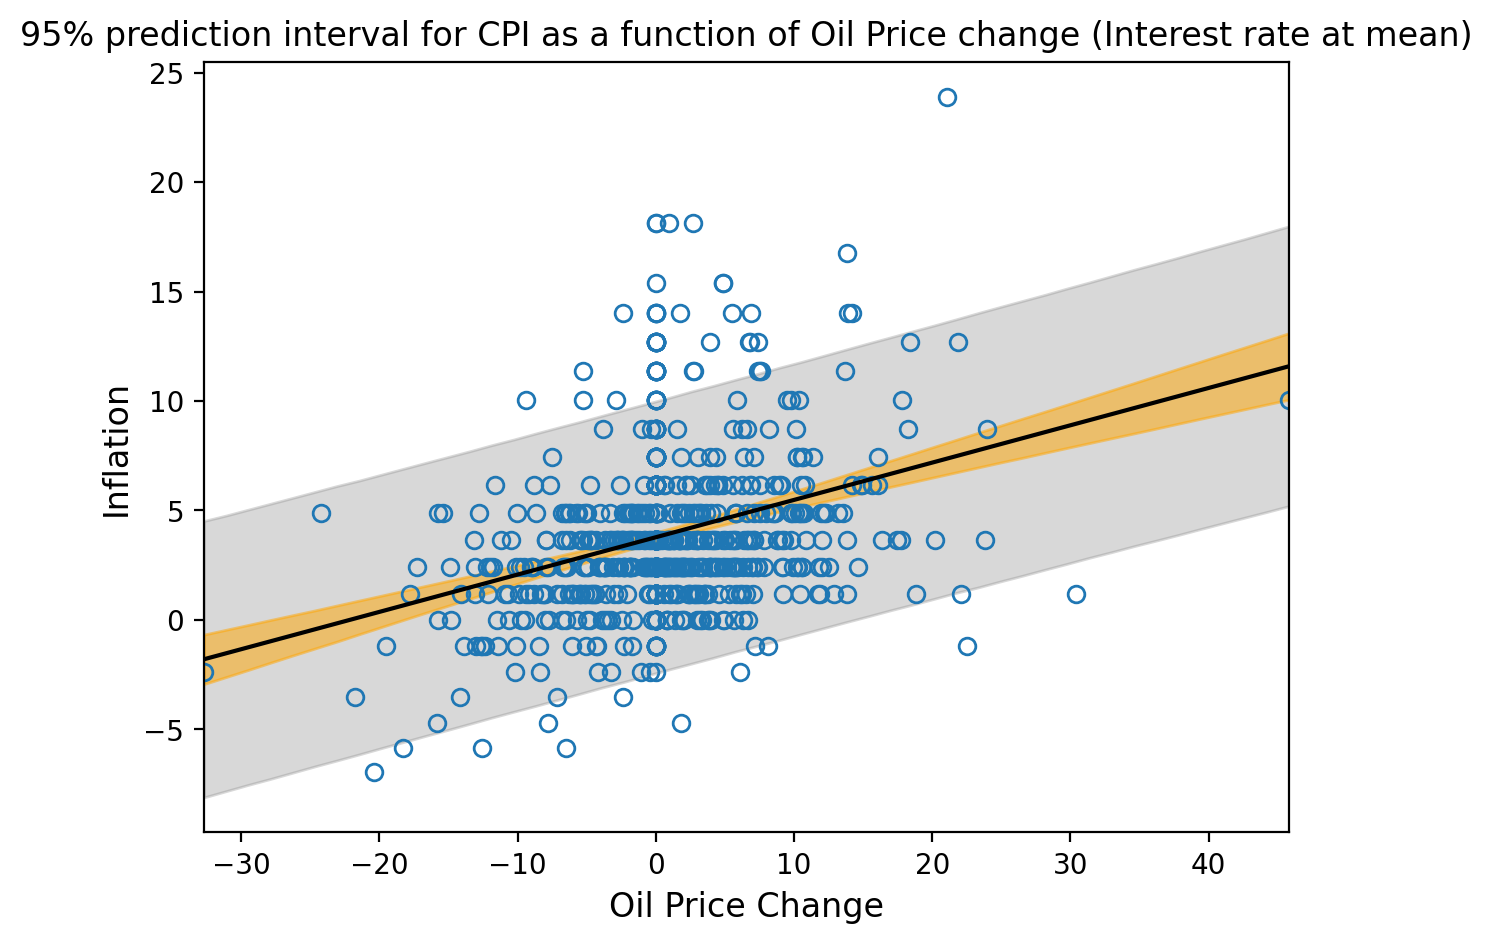

In [ ]:
## Prediction plot for CPI from Interest Rate and Oil MCMC, holding interest rate at its mean:

prob = 0.95 ## for credible intervals

xmin = data_new['Oil'].min()
xmax = data_new['Oil'].max()
xmean = data_new['Oil'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_project2_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_project2_mcmc_samples['beta_W'])[None, :]
sigma_samples = array(model_project2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_new['Oil'], data_new['CPI.U'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for CPI as a function of Oil Price change (Interest rate at mean)')
xlabel('Oil Price Change', fontsize=12)
ylabel('Inflation', fontsize=12);

As can be seen, once those extreme datapoints have been dropped, the regression fit between Inflation and Oil Price change is much better. As such, we conclude that our linearity assumption on the relationship between inflation and oil price is reasonable.

**GDP analysis without influential datapoints**:

Returning to our MCMC analysis of CPI versus GDP growth, we can clearly see that the credibility interval plot for CPI versus GDP growth is heavily skewed by several extreme datapoints; these points correspond to extraordinary economic shocks that brought extreme overnight fluctuations in the price of oil. As such, we investigate how our MCMC model behaves if we drop these extreme influential data points, to verify whether our linearity assumption is acceptable.  



In [ ]:
gdp_threshold = data_all['GDP'].quantile([0.05, 0.95]).values
gdp_low_threshold, gdp_high_threshold = gdp_threshold

data_filtered = data_all[(data_all['GDP'] > gdp_low_threshold) & (data_all['GDP'] < gdp_high_threshold)]

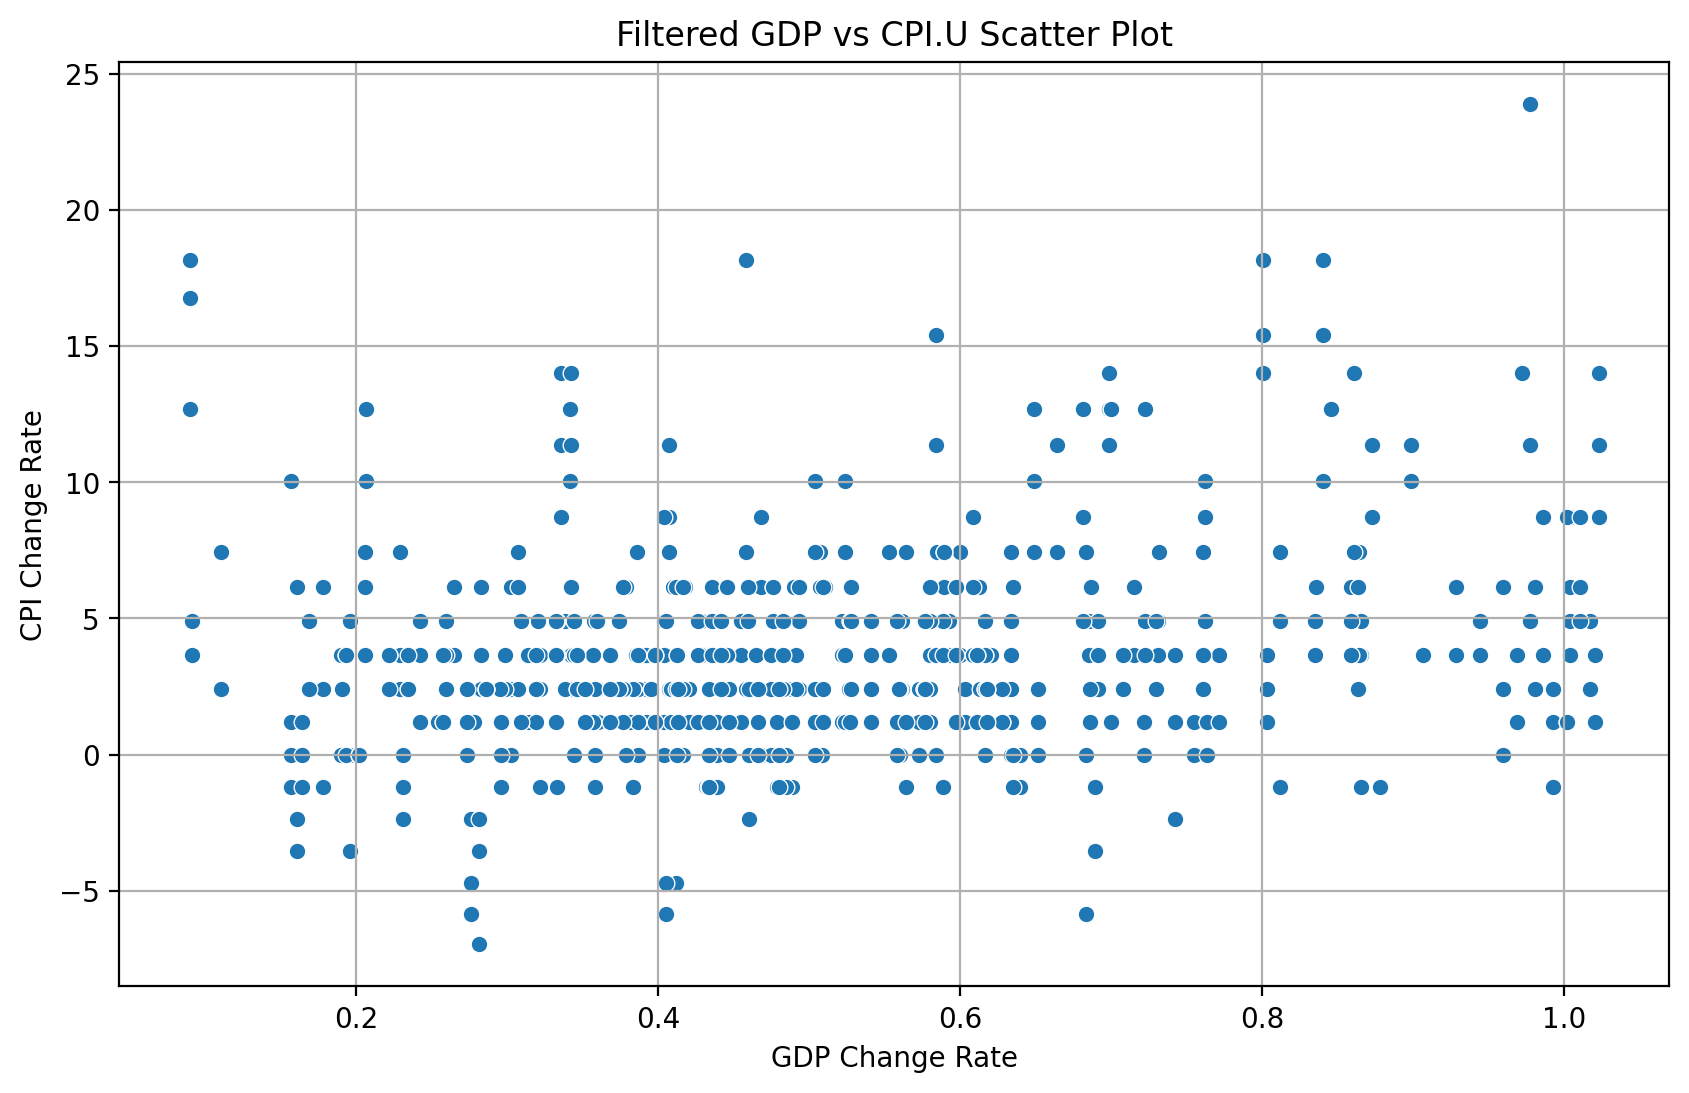

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GDP', y='CPI.U', data=data_filtered)
plt.title('Filtered GDP vs CPI.U Scatter Plot')
plt.xlabel('GDP Change Rate')
plt.ylabel('CPI Change Rate')
plt.grid(True)
plt.show()

Our prior for GDP still takes the form:

\begin{align*}
    CPI_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{G}(G_{i}-\bar{G}) \\
    \alpha &\sim \text{Normal}(4, 2) \\
    \beta_{G} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $G_i$ denotes the GDP growth rate.

In [ ]:
with pm.Model() as model_gdp2:
    sigma = pm.Exponential('sigma', 0.5)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    _mu = alpha + beta_G*(data_filtered['GDP']-data_filtered['GDP'].mean())
    mu = pm.Deterministic('mu', _mu)
    CPI = pm.Normal('CPI', mu=mu, sigma=sigma, observed=data_filtered['CPI.U'])
    _model_gdp2_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gdp2_mcmc_samples = _model_gdp2_mcmc_samples.posterior.to_dataframe()
model_gdp2_mcmc_samples

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


beta_G     alpha     sigma        mu
chain draw mu_dim_0                                        
0     0    0         3.734488  3.718804  3.518545  5.048465
           1         3.734488  3.718804  3.518545  2.807026
           2         3.734488  3.718804  3.518545  2.807026
           3         3.734488  3.718804  3.518545  2.807026
           4         3.734488  3.718804  3.518545  2.876767
...                       ...       ...       ...       ...
3     999  674       3.050219  3.636977  3.480319  2.987340
           675       3.050219  3.636977  3.480319  2.987340
           676       3.050219  3.636977  3.480319  2.987340
           677       3.050219  3.636977  3.480319  4.136025
           678       3.050219  3.636977  3.480319  4.136025

[2716000 rows x 4 columns]

<Axes: >

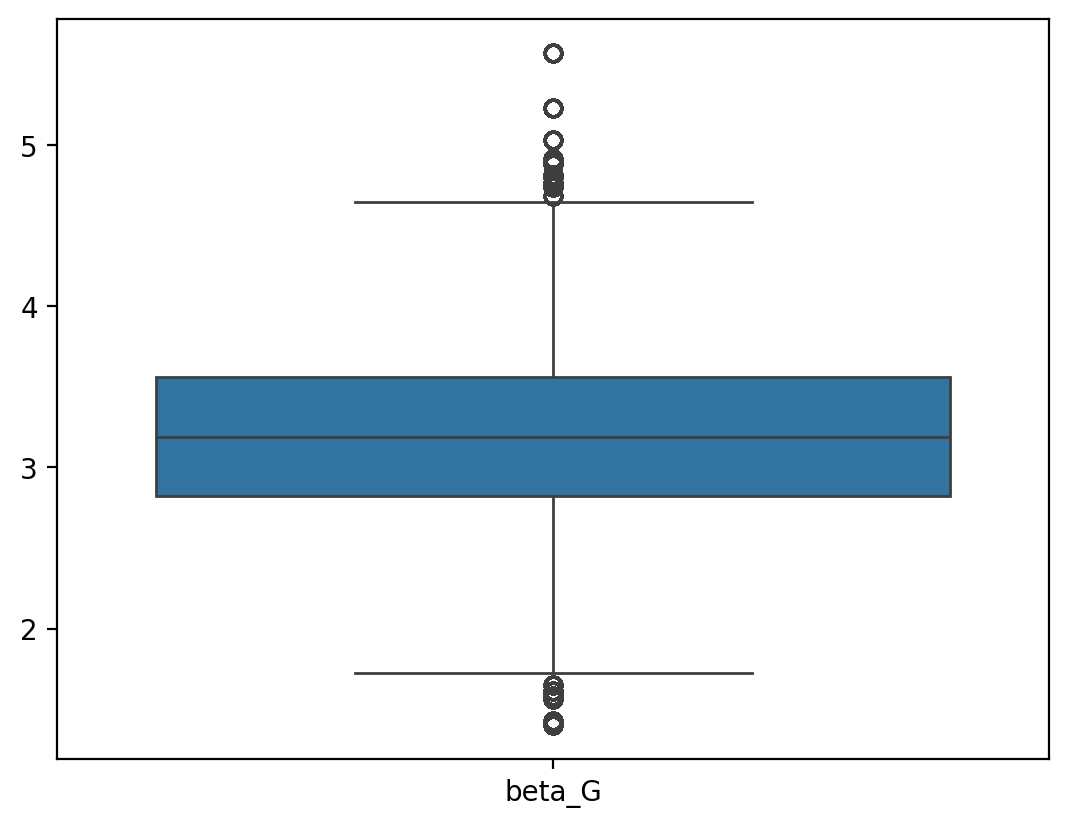

In [ ]:
sns.boxplot(data=model_gdp2_mcmc_samples[['beta_G']])

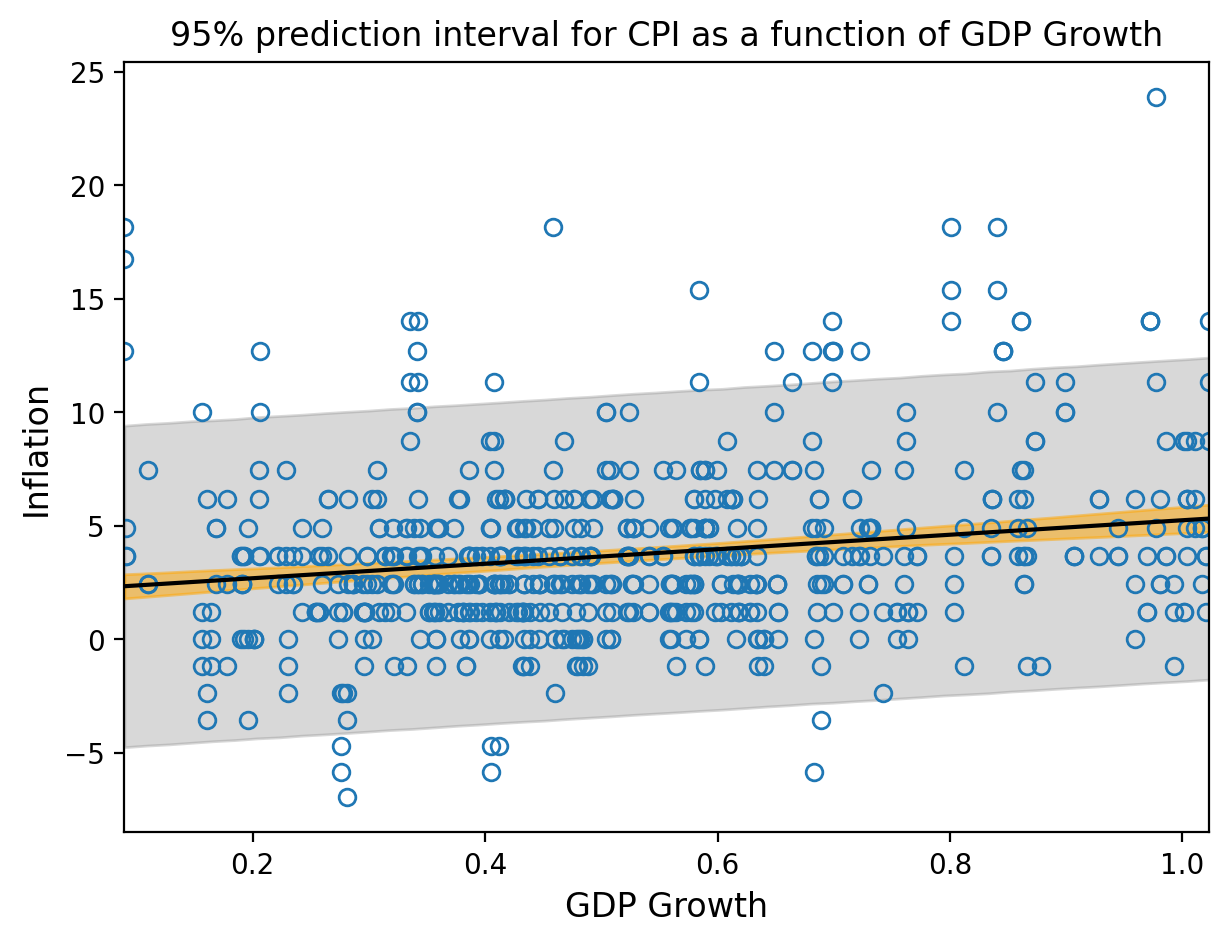

In [ ]:
## Prediction plot for CPI from GDP MCMC:

prob = 0.95 ## for credible intervals

xmin = data_filtered['GDP'].min()
xmax = data_filtered['GDP'].max()
xmean = data_filtered['GDP'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gdp2_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gdp2_mcmc_samples['beta_G'])[None, :]
sigma_samples = array(model_gdp2_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_filtered['GDP'], data_filtered['CPI.U'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for CPI as a function of GDP Growth')
xlabel('GDP Growth', fontsize=12)
ylabel('Inflation', fontsize=12);

After excluding extreme GDP data, we still see a strong positive correlation between GDP and CPI change rates, suggesting our assumption of linearity holds. The 95% credibility interval further confirms this.

# Part 2:

## The Influential Factors of Gold Price

Now that we have studied and ascertained the factors controlling inflation, we now examine whether gold serves as a useful asset in helping to protect against inflation. In this case, our gold price data begins in January 1971, so we pre-process our dataset to now include the 'Gold Price' column and to only contain the data from 1971 onward.

The pertinent Directed Acyclic Graph for the expected relationship between GDP, S&P 500 stock index, CPI inflation, and Gold price, takes the form given below:

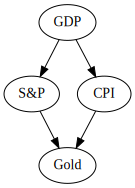

In [ ]:
CausalGraphicalModel(
    nodes=['Gold', 'CPI', 'GDP', 'S&P'], edges=[('CPI', 'Gold'), ('S&P', 'Gold'), ('GDP', 'CPI'), ('GDP', 'S&P')]
).draw()

The DAG can be summarized as follows:

* GDP influences both the S&P 500 stock index and CPI inflation
* The stock market behavior and CPI inflation both influence the price growth of gold, as gold is viewed as a 'hedge' (protection) against fluctuations in stock market and inflation turbulence.
* Because gold price is a market product, it is not directly influenced by GDP (economic well-being), but is indirectly influenced through the resultant trends of the stock/asset market.

In [ ]:
data_pt2 = data_all[data_all['GoldChange'].notnull()]
data_pt2

,Date,BOGMBASE,Money Base Change,DPRIME,GDP,SPIndex,Oil,CPI.U,GoldChange,Inf_Prev
132,1971-01-01,81200,0.246914,6.75,1.405461,0.0415,0.000000,3.659998,-0.0535,6.167781
133,1971-02-01,80600,-0.738916,6.00,0.616227,0.0283,0.000000,0.000000,2.0627,6.167781
134,1971-03-01,80800,0.248139,5.75,0.616227,0.0367,0.000000,3.659998,1.7060,6.167781
135,1971-04-01,81600,0.990099,5.25,0.616227,-0.0111,0.000000,3.659998,0.5161,6.167781
136,1971-05-01,82400,0.980392,5.38,0.613272,-0.0160,0.000000,6.167781,1.2067,3.659998
...,...,...,...,...,...,...,...,...,...,...
750,2023-02-01,5321600,-0.138863,7.50,0.309099,-0.0259,-1.651306,4.907021,-5.6535,8.731066
751,2023-03-01,5571500,4.695956,7.75,0.309099,0.0400,-4.620591,1.206622,1.8364,12.682503
752,2023-04-01,5593100,0.387687,8.00,0.309099,0.0060,8.419760,4.907021,-4.7479,4.907021
753,2023-05-01,5569600,-0.420161,8.00,0.685690,0.0480,-9.905601,1.206622,-0.9716,11.350967


In [ ]:
data_pt2['GoldChange'].mean()

0.7635791332263243

## Gold price, Inflation & S&P 500:

Now, we turn our attention to analyzing the significance of the relationship between inflation and changes in the gold price. Observing the DAG plot above, we see that there are two paths between CPI and Gold price; to close the second (unwanted) path, we condition on the GDP variable above, and hence write a model that includes the S&P 500 stock index and CPI versus the Gold price.

Note that, as explained earlier, our gold data only begins in 1971, so we first filter out all data points before that time. Furthermore, we observe that the mean for the price change of gold is approximately 0.76%, so we take the prior $\alpha$ to have a mean of 0.75 and standard deviation of 0.2.

As such, we take the following prior:

\begin{align*}
    Gold_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{C}(C_{i}-\bar{C}) + \beta_{S}(S_{i}-\bar{S}) \\
    \alpha &\sim \text{Normal}(0.75, 0.2) \\
    \beta_{C} &\sim \text{Normal}(0, 1) \\
    \beta_{S} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}
  Where $C_i$ denotes the CPI inflation rate and $S_i$ denotes the S&P 500 growth rate.

In [ ]:
with pm.Model() as model_gold1:
    sigma = pm.Exponential('sigma', 0.5)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_S = pm.Normal('beta_S', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0.75, sigma=0.2)
    _mu = alpha + beta_C*(data_pt2['CPI.U']-data_pt2['CPI.U'].mean()) + beta_S*(data_pt2['SPIndex']-data_pt2['SPIndex'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_pt2['GoldChange'])
    _model_gold1_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold1_mcmc_samples = _model_gold1_mcmc_samples.posterior.to_dataframe()
model_gold1_mcmc_samples

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


beta_C    beta_S     alpha     sigma        mu
chain draw mu_dim_0                                                  
0     0    0         0.253186  0.215852  0.928408  5.287642  0.813438
           1         0.253186  0.215852  0.928408  5.287642 -0.116073
           2         0.253186  0.215852  0.928408  5.287642  0.812402
           3         0.253186  0.215852  0.928408  5.287642  0.802084
           4         0.253186  0.215852  0.928408  5.287642  1.435963
...                       ...       ...       ...       ...       ...
3     999  618       0.251050  0.569370  0.476917  5.115733  0.649069
           619       0.251050  0.569370  0.476917  5.115733 -0.242393
           620       0.251050  0.569370  0.476917  5.115733  0.667232
           621       0.251050  0.569370  0.476917  5.115733 -0.237838
           622       0.251050  0.569370  0.476917  5.115733  0.055563

[2492000 rows x 5 columns]

<Axes: >

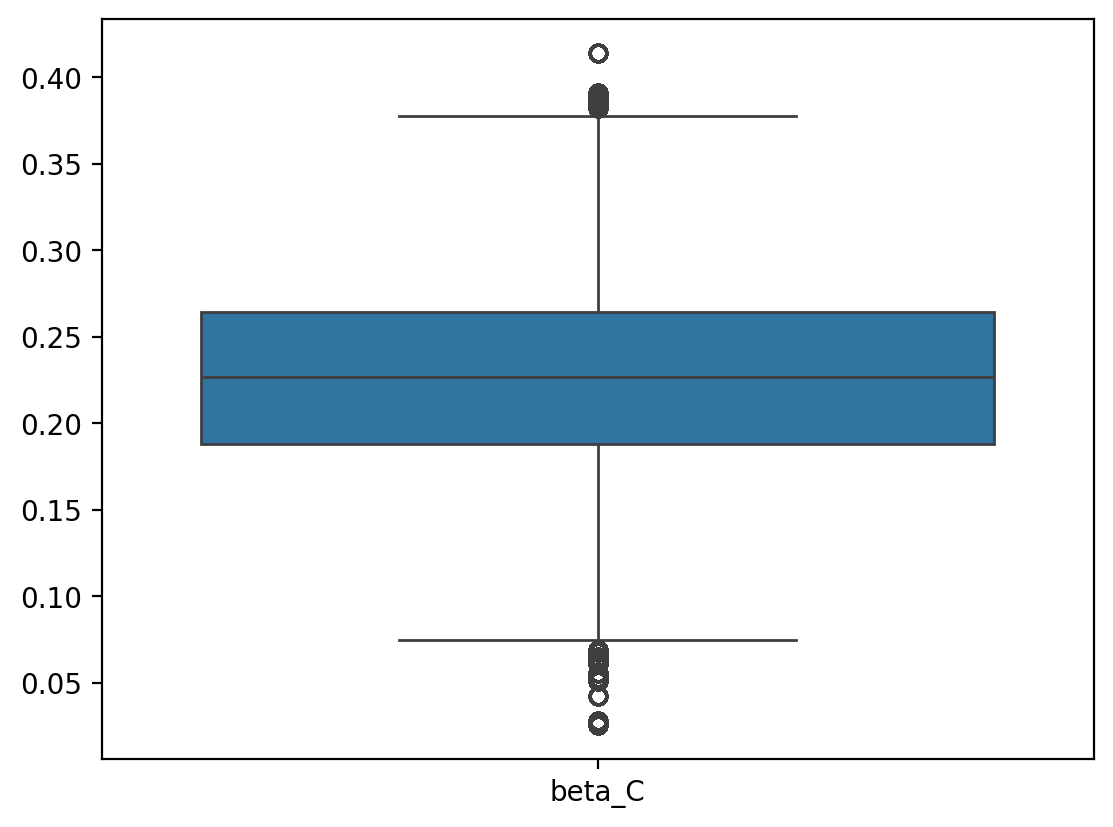

In [ ]:
sns.boxplot(data=model_gold1_mcmc_samples[['beta_C']])

<Axes: >

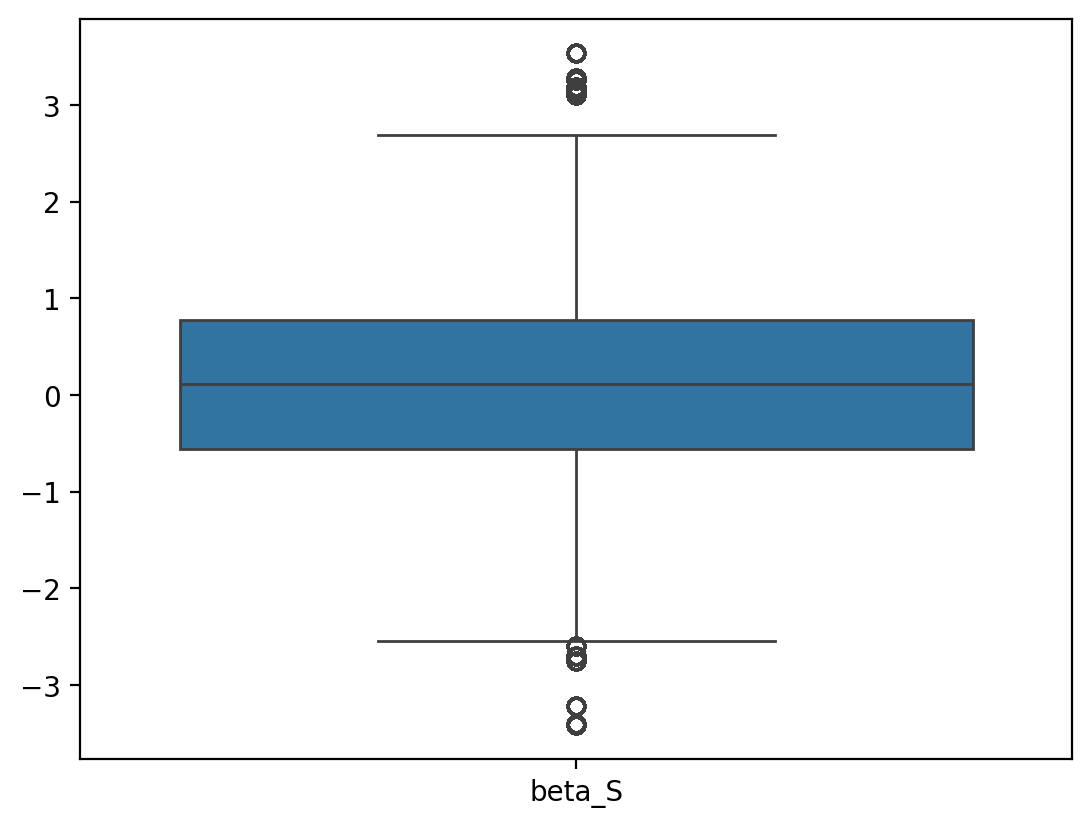

In [ ]:
sns.boxplot(data=model_gold1_mcmc_samples[['beta_S']])

As can be seen, the boxplot for $\beta_C$ is clearly above 0 with an estimated median between 0.20 and 0.25, indicating that **there is a significant positive relationship between CPI Inflation and changes in gold price**.

However, the boxplot for $\beta_S$ is very closely centered to 0, indicating that **there is no significant relationship between changes in gold price and changes in the S&P 500 stock index**.

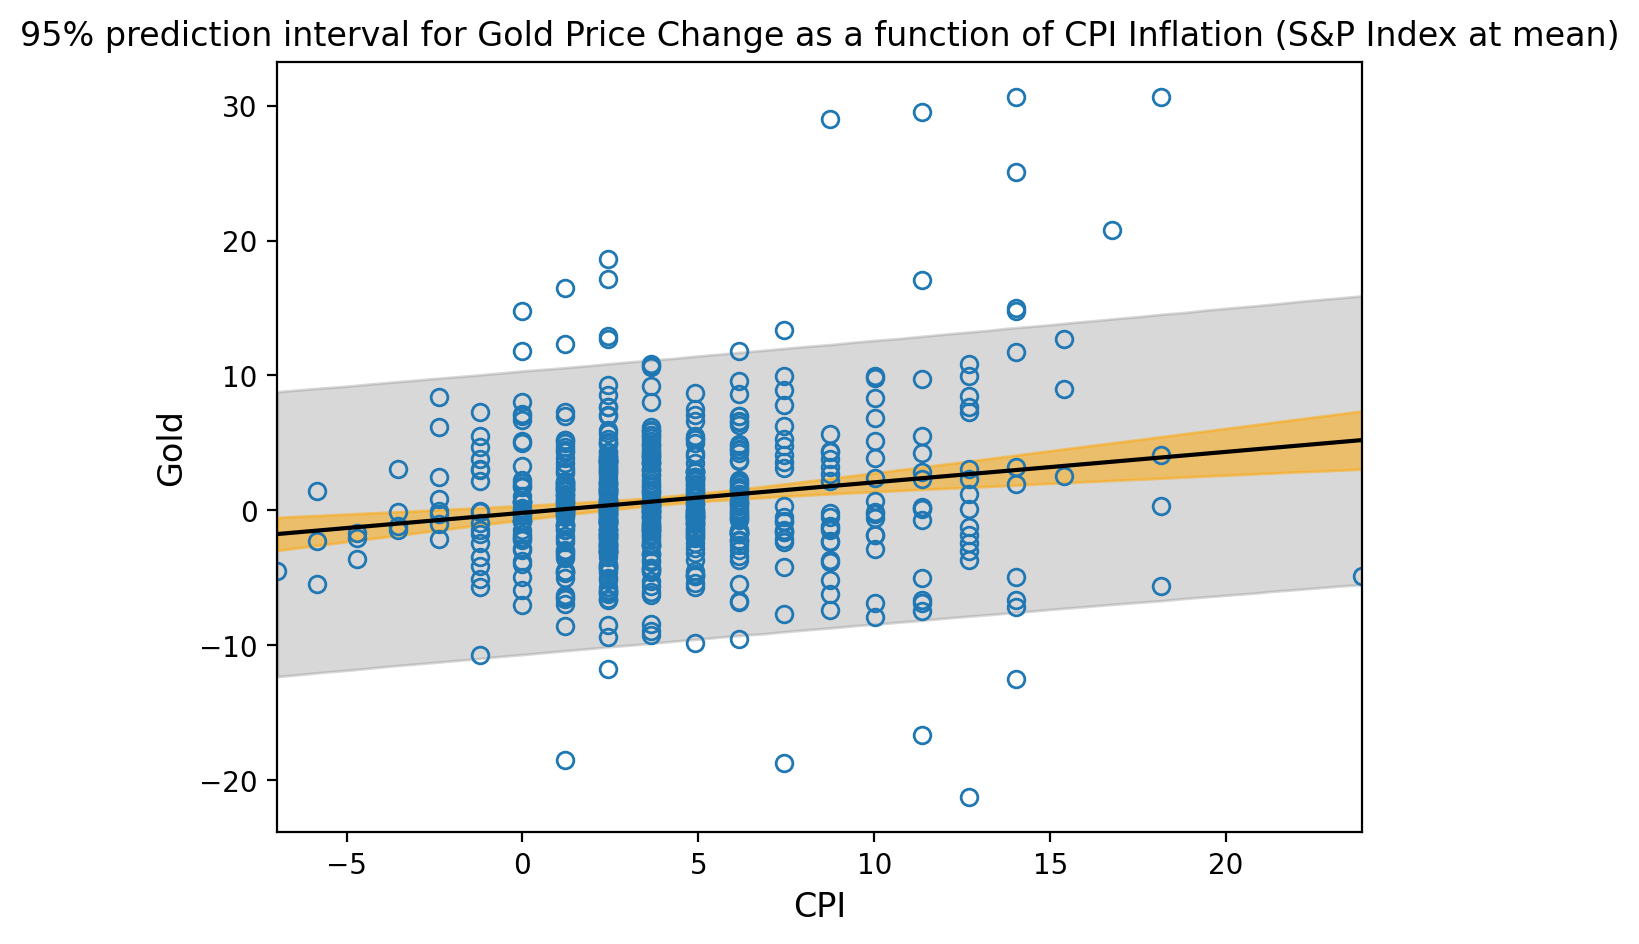

In [ ]:
## Prediction plot for Gold from CPI and S&P MCMC, holding S&P at its mean:

prob = 0.95 ## for credible intervals

xmin = data_pt2['CPI.U'].min()
xmax = data_pt2['CPI.U'].max()
xmean = data_pt2['CPI.U'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold1_mcmc_samples['beta_C'])[None, :]
sigma_samples = array(model_gold1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_pt2['CPI.U'], data_pt2['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of CPI Inflation (S&P Index at mean)')
xlabel('CPI', fontsize=12)
ylabel('Gold', fontsize=12);

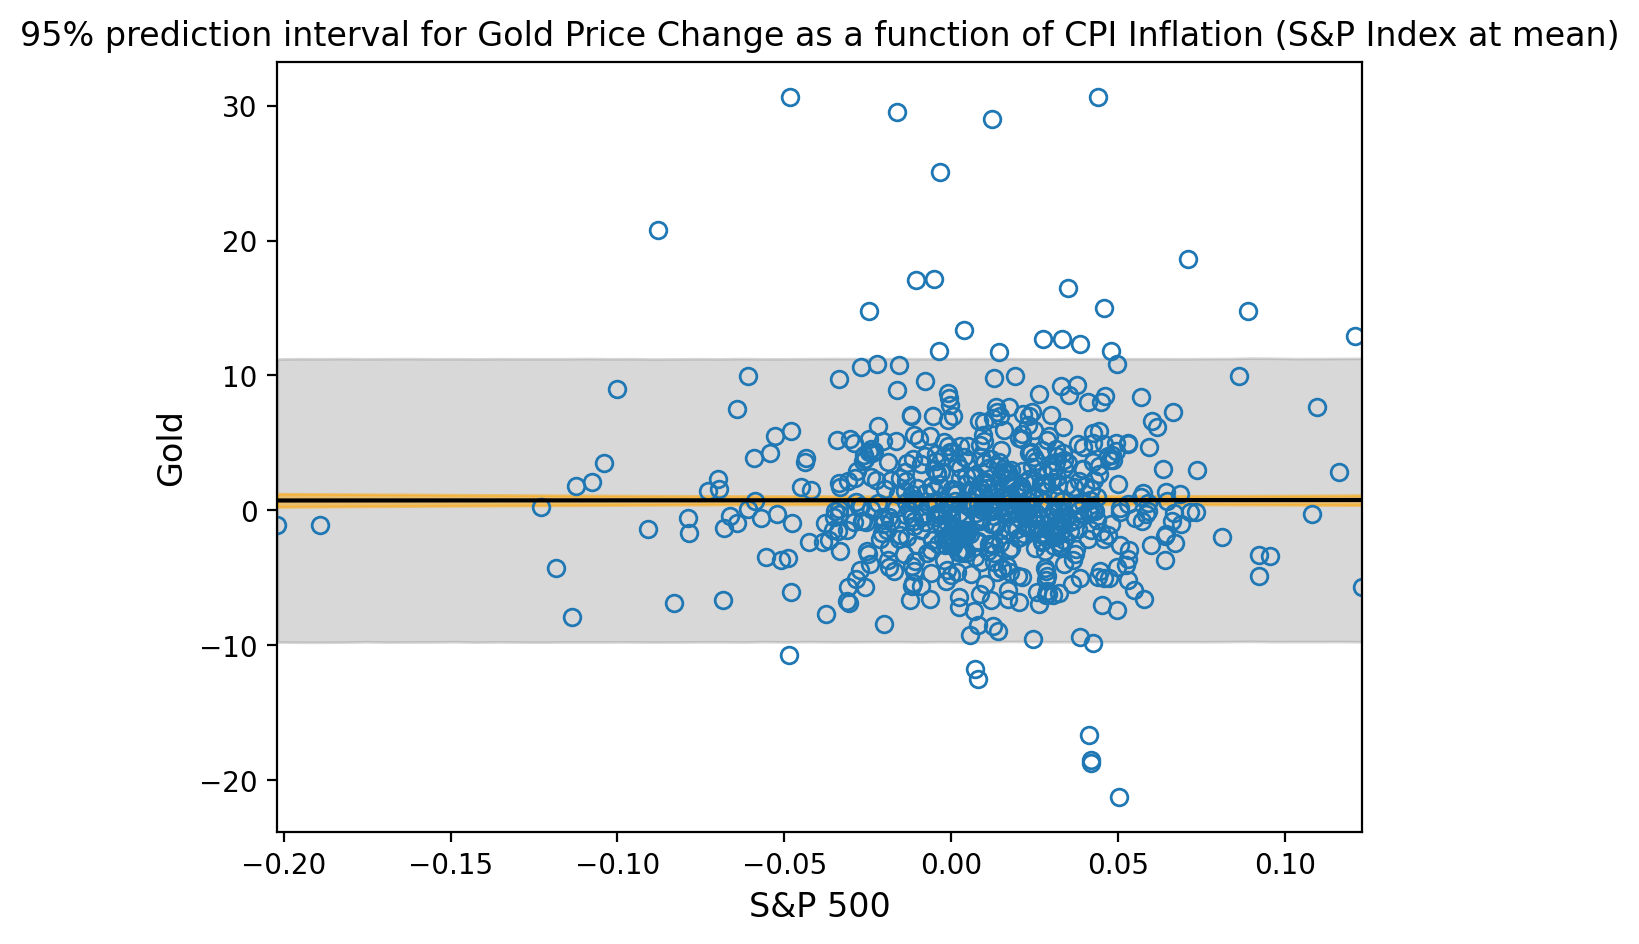

In [ ]:
## Prediction plot for Gold from CPI and S&P MCMC, holding S&P at its mean:

prob = 0.95 ## for credible intervals

xmin = data_pt2['SPIndex'].min()
xmax = data_pt2['SPIndex'].max()
xmean = data_pt2['SPIndex'].mean()


N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(model_gold1_mcmc_samples['alpha'])[None, :]
beta_samples = array(model_gold1_mcmc_samples['beta_S'])[None, :]
sigma_samples = array(model_gold1_mcmc_samples['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + beta_samples.mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + beta_samples*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples,
    sigma_samples,
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_pt2['SPIndex'], data_pt2['GoldChange'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('95% prediction interval for Gold Price Change as a function of CPI Inflation (S&P Index at mean)')
xlabel('S&P 500', fontsize=12)
ylabel('Gold', fontsize=12);

Overall, our analysis indicates that there is a significant positive relationship between inflation and gold price change, but not between S&P 500 stock index and gold price change. This leads us to conclude that gold is a valuable asset in helping to hedge against inflation, and is particularly useful because of its observed resilience to stock market trends.

## Gold Price & GDP:

Now, we turn our attention to analysing the effect of GDP on gold price. For this purpose, we simply condition on S&P 500 and CPI. As such, our prior takes the form:

\begin{align*}
    Gold_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{G}(G_{i}-\bar{G}) \\
    \alpha &\sim \text{Normal}(0.75, 0.2) \\
    \beta_{G} &\sim \text{Normal}(0, 1) \\
    \sigma &\sim  \text{Exponential}(0.5)
  \end{align*}

In [ ]:
with pm.Model() as model_gold2:
    sigma = pm.Exponential('sigma', 0.5)
    beta_G = pm.Normal('beta_G', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=0.75, sigma=0.2)
    _mu = alpha + beta_G*(data_pt2['GDP']-data_pt2['GDP'].mean())
    mu = pm.Deterministic('mu', _mu)
    Gold = pm.Normal('Gold', mu=mu, sigma=sigma, observed=data_pt2['GoldChange'])
    _model_gold2_mcmc_samples = pm.sample(1000, tune=1000, chains=4)
model_gold2_mcmc_samples = _model_gold2_mcmc_samples.posterior.to_dataframe()
model_gold2_mcmc_samples

beta_G     alpha     sigma        mu
chain draw mu_dim_0                                        
0     0    0        -0.781996  0.507718  5.744789 -0.184156
           1        -0.781996  0.507718  5.744789  0.433022
           2        -0.781996  0.507718  5.744789  0.433022
           3        -0.781996  0.507718  5.744789  0.433022
           4        -0.781996  0.507718  5.744789  0.435332
...                       ...       ...       ...       ...
3     999  618       0.768269  0.725392  5.326948  0.562820
           619       0.768269  0.725392  5.326948  0.562820
           620       0.768269  0.725392  5.326948  0.562820
           621       0.768269  0.725392  5.326948  0.852143
           622       0.768269  0.725392  5.326948  0.852143

[2492000 rows x 4 columns]

<Axes: >

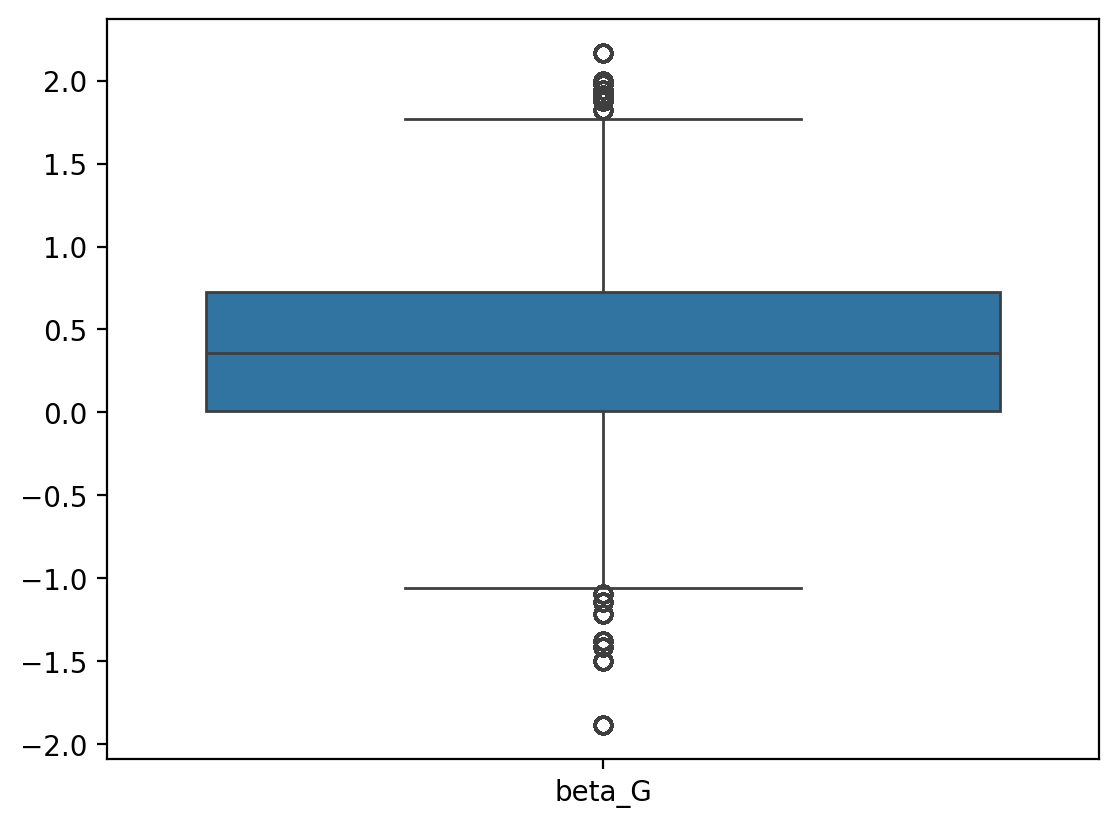

In [ ]:
sns.boxplot(data=model_gold2_mcmc_samples[['beta_G']])

As can be seen, the boxplot for $\beta_G$ is centered relatively close to 0, indicating that there is likely not a notable relationship between GDP growth and Gold price changes.

**To put credibility interval plot for Gold vs. GDP!!!**


## Summary & Interpretation of Results: